# Magma-Atmosphere Coupling of Hot Sub-Neptunes

## Import libraries

In [1]:
from atmodeller import debug_logger, debug_file_logger
from atmodeller.constraints import (
    SystemConstraints, ElementMassConstraint, BufferedFugacityConstraint, ActivityConstraint
    )
from atmodeller.thermodata.redox_buffers2 import (
    IronWustiteBuffer, IronWustiteBufferBallhaus, IronWustiteBufferFischer, 
    IronWustiteBufferHirschmann,  IronWustiteBufferHirschmann21
    )
from atmodeller.thermodata.fastchem_style import ThermodynamicDatasetFastchemStyle
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet
from atmodeller.initial_solution import InitialSolutionDict, InitialSolutionLast
from atmodeller.core import GasSpecies, Species, LiquidSpecies, SolidSpecies
from atmodeller.solubility.hydrogen_species import H2_basalt_hirschmann, H2O_peridotite_sossi
from atmodeller.solubility.carbon_species import (
    CO2_basalt_dixon, CO_basalt_yoshioka, CH4_basalt_ardia
)
from atmodeller.solubility.other_species import N2_basalt_libourel, He_basalt
from atmodeller.utilities import earth_oceans_to_kg
from atmodeller.eos.interfaces import RealGas
from atmodeller.eos.saxena import get_saxena_eos_models, H2_SS92
from atmodeller.eos.holland import get_holland_eos_models, H2_CORK_HP91
from atmodeller.eos.holley import get_holley_eos_models, H2_Beattie_holley
from atmodeller.eos.chabrier import get_chabrier_eos_models, H2_CD21, He_CD21, H2HeY0275_CD21
from atmodeller.eos.vanderwaals import (
    get_vanderwaals_eos_models, H2_Lide_vanderwaals, H4Si_Lide_vanderwaals
)

from atmodeller import ATMOSPHERE, GAS_CONSTANT_BAR

import logging
# logger = debug_file_logger()
logger = debug_logger()
logger.setLevel(logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.optimize import curve_fit 


model_holland = H2_CORK_HP91
model_holley = H2_Beattie_holley
model_saxena = H2_SS92
model_chabrier = H2_CD21
model_chabrier_He = He_CD21
model_vanderwaals = H2_Lide_vanderwaals
model_vanderwaals_H4Si = H4Si_Lide_vanderwaals

## Information on Global Planet Properties

planet_mass = 5 * 5.972e24 # kg 

surface_radius = 1.53 * 6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus 

surface_temperature=3000 # kelvin

log_fO2_dIW = -5

massH_ocean = 963 # mass of H equivalent to 963 Earth water oceans

h_kg: float = earth_oceans_to_kg(massH_ocean)

hmp: float = h_kg / planet_mass * 100 # = 1 wt% H 
 
he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

c_kg_solar: float = h_kg * 0.22 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

n_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

si_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)



Present-day solar composition \
Table 8 - Lodders et al. (2009) Springer book chapter 

| Element    | Mass % |
|------------|--------|
| H (=X)     | 73.9   |
| He (=Y)    | 24.69  |
| O          | 0.63   |
| C          | 0.22   |
| Ne         | 0.17   |
| Fe         | 0.12   |
| N          | 0.07   |
| Si         | 0.07   |
| Mg         | 0.06   |
| S          | 0.03   |
| others     | 0.04   |
| total (=Z) | 1.41   |

Table 6 - Lodders et al. (2009) Springer book chapter 

| Element | A (log N(H) = 12) |
|---------|-------------------|
| H       | 12                |
| He      | 10.93             |
| C       | 8.39              |
| N       | 7.86              |
| O       | 8.73              |
| Ne      | 8.05              |
| Na      | 6.29              |
| Mg      | 7.54              |
| Al      | 6.46              |
| Si      | 7.53              |
| P       | 5.45              |
| S       | 7.16              |
| Cl      | 5.25              |
| Ar      | 6.5               |
| K       | 5.11              |
| Ca      | 6.31              |
| Ti      | 4.93              |
| V       | 3.99              |
| Fe      | 7.46              |


In [3]:
H_logN = 12
He_logN = 10.93
C_logN = 8.39
N_logN = 7.86
O_logN = 8.73
Ne_logN = 8.05
Na_logN = 6.29
Mg_logN = 7.54
Al_logN = 6.46
Si_logN = 7.53
P_logN = 5.45
S_logN = 7.16
Cl_logN = 5.25
Ar_logN = 6.5
K_logN = 5.11
Ca_logN = 6.31
Ti_logN = 4.93 
V_logN = 3.99  
Fe_logN = 7.46 

# Basic Tests and Examples

## a. Compare H2 fugacity coefficients

In [ ]:
pressures = np.logspace(0, 6, num=200)
temperature = 3500

fc_holland = []
fc_holley = []
fc_saxena = []
fc_chabrier = []
fc_chabrier_He = []
fc_vanderwaals = []
fc_vanderwaals_H4Si = []
fc_vanderwaals_OSi = []


for pressure in pressures:
    fc_holland.append(model_holland.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_holley.append(model_holley.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_saxena.append(model_saxena.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_chabrier.append(model_chabrier.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_chabrier_He.append(model_chabrier_He.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_vanderwaals.append(model_vanderwaals.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_vanderwaals_H4Si.append(model_vanderwaals_H4Si.fugacity_coefficient(temperature=temperature, pressure=pressure))

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, fc_holland, color='orange', lw=2, label=r'Holland')
ax1.plot(pressures/1e3, fc_holley, color='blue', lw=2, label=r'Holley')
ax1.plot(pressures/1e3, fc_saxena, color='pink', lw=2, label=r'Saxena')
ax1.plot(pressures/1e3, fc_chabrier, color='green', lw=2, label=r'Chabrier')
ax1.plot(pressures/1e3, fc_chabrier_He, color='yellow', lw=2, label=r'Chabrier He')
ax1.plot(pressures/1e3, fc_vanderwaals, color='cyan', lw=2, label=r'van der Waals')
ax1.plot(pressures/1e3, fc_vanderwaals_H4Si, color='red', lw=2, label=r'van der Waals SiH4')

ax1.set_title('H2 fugacity coefficients at %d K'%temperature)

ax1.set_ylim([0.1,1e10])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'H2 Fugacity Coefficient', fontsize=14)

ax1.legend(ncol=1, loc='upper left')
plt.savefig('H2Hefugcoeff_%dK.pdf'%temperature, bbox_inches='tight')
plt.savefig('H2Hefugcoeff_%dK.png'%temperature, bbox_inches='tight')
plt.show()

In [ ]:
pressures = np.logspace(0, 6, num=200)
temperature = 3000 #k

vol_holland = []
vol_holley = []
vol_saxena = []
vol_chabrier = []
vol_vanderwaals = []

for pressure in pressures:
    vol_holland.append(model_holland.volume(temperature=temperature, pressure=pressure))
    vol_holley.append(model_holley.volume(temperature=temperature, pressure=pressure))
    vol_saxena.append(model_saxena.volume(temperature=temperature, pressure=pressure))
    vol_chabrier.append(model_chabrier.volume(temperature=temperature, pressure=pressure))
    vol_vanderwaals.append(model_vanderwaals.volume(temperature=temperature, pressure=pressure))

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, vol_holland, color='orange', lw=2, label=r'Holland')
ax1.plot(pressures/1e3, vol_holley, color='blue', lw=2, label=r'Holley')
ax1.plot(pressures/1e3, vol_saxena, color='red', lw=2, label=r'Saxena')
ax1.plot(pressures/1e3, vol_chabrier, color='green', lw=2, label=r'Chabrier')
ax1.plot(pressures/1e3, vol_vanderwaals, color='cyan', lw=2, label=r'van der Waals')

ax1.set_title('Volume at %d K'%temperature)

ax1.set_ylim([1e-10,1e0])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'Volume [m$^3$]', fontsize=14)

ax1.legend(ncol=1, loc='upper left')
plt.savefig('H2vol_%dK.pdf'%temperature, bbox_inches='tight')
plt.savefig('H2vol_%dK.png'%temperature, bbox_inches='tight')
plt.show()

## b. Compare fO2 buffers

In [ ]:
pressures = np.logspace(0, 6, num=200)
temperature = 3500 #k

log10fO2_hirschmann21 = np.array([IronWustiteBufferHirschmann21.get_log10_value(IronWustiteBufferHirschmann21(), temperature, pressure) for pressure in pressures])
log10fO2_hirschmann = np.array([IronWustiteBufferHirschmann.get_log10_value(IronWustiteBufferHirschmann(), temperature, pressure) for pressure in pressures])
log10fO2_ballhaus = np.array([IronWustiteBufferBallhaus.get_log10_value(IronWustiteBufferBallhaus(), temperature, pressure) for pressure in pressures])
log10fO2_fischer = np.array([IronWustiteBufferFischer.get_log10_value(IronWustiteBufferFischer(), temperature, pressure) for pressure in pressures])

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, log10fO2_hirschmann21, color='orange', lw=2, label=r'Hirschmann et al. (2021)')
ax1.plot(pressures/1e3, log10fO2_hirschmann, color='blue', lw=2, label=r'Hirschmann et al. (2008)')
ax1.plot(pressures/1e3, log10fO2_ballhaus, color='red', lw=2, label=r'Ballhaus et al. (1991)')
ax1.plot(pressures/1e3, log10fO2_fischer, color='green', lw=2, label=r'Fischer et al. (2011)')

ax1.set_title(r'log$_{10} f_{O_2}$ at %d K'%temperature)

#ax1.set_ylim([0.1,1e10])

ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'log$_{10} f_{O_2}$ ', fontsize=14)

# ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
# ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

# ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=1, loc='upper left')
plt.savefig('log10fO2_%dK.pdf'%temperature, bbox_inches='tight')
plt.savefig('log10fO2_%dK.png'%temperature, bbox_inches='tight')
plt.show()

## c. Example with Element Mass Constraint for Si

In [11]:
planet_mass=5*5.972e24 # kg
surface_radius=1.53*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3000 # kelvin

massH_ocean = 963 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
O2Si_g = GasSpecies("O2Si")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_g, O2Si_l])

constraint: SystemConstraints = SystemConstraints(
    [
        #BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=-1, pressure=1)),
        ElementMassConstraint("O", value=si_kg_magma/4*6.7),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
#        ActivityConstraint(O2Si_l, 1),
    ]
)

system = InteriorAtmosphereSystem(species=species, planet=planet)

system.solve(constraint)

print(system.output)

ideal_solution = system.solution.solution_dict()

logger.info("Ideal solution = %s", ideal_solution)

#system.output("Example c", to_excel=True, to_pickle=False)

[11:37:35 - atmodeller.core                - INFO     ] - Creating a planet
[11:37:35 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[11:37:35 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[11:37:35 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[11:37:35 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[11:37:35 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[11:37:35 - atmodeller.core                - INFO     ] - melt_composition = None
[11:37:35 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[11:37:35 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[11:37:35 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[11:37:35 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[11:37:35 - atmodeller.core 

{'H2_g': [{'pressure': 35.28078031189026, 'fugacity': 35.28078031189031, 'number_density': 8.517921719396762e+25, 'atmosphere_mass': 1.7929585553982306e+19, 'melt_ppmw': 0.0, 'melt_mass': 0.0, 'solid_ppmw': 0.0, 'solid_mass': 0.0, 'fugacity_coefficient': 1.0000000000000013, 'volume_mixing_ratio': 8.088811249924001e-05, 'molar_mass': 0.002015882, 'total_mass': 1.7929585553982306e+19, 'atmosphere_moles': 8.894164218928641e+21, 'melt_moles': 0.0, 'solid_moles': 0.0, 'total_moles': 8.894164218928641e+21}], 'H2O_g': [{'pressure': 293679.8685227622, 'fugacity': 293679.8685227628, 'number_density': 7.090382096216155e+29, 'atmosphere_mass': 1.333774236429152e+24, 'melt_ppmw': 0.0, 'melt_mass': 0.0, 'solid_ppmw': 0.0, 'solid_mass': 0.0, 'fugacity_coefficient': 1.0000000000000013, 'volume_mixing_ratio': 0.6733187314404514, 'molar_mass': 0.018015287, 'total_mass': 1.333774236429152e+24, 'atmosphere_moles': 7.403569182268103e+25, 'melt_moles': 0.0, 'solid_moles': 0.0, 'total_moles': 7.403569182268

## d. Example with Element Mass Constraint for Si and Mg

In [ ]:
planet_mass=5*5.972e24 # kg
surface_radius=1.53*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3000 # kelvin

massH_ocean = 963 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIW = -5

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
O2Si_g = GasSpecies("O2Si")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
OMg_l = LiquidSpecies("OMg")
Mg_g = GasSpecies("Mg")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_g, O2Si_l, OMg_l, Mg_g])

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
        ElementMassConstraint("Mg", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species, planet=planet)

system.solve(constraint)

print(system.output)

ideal_solution = system.solution.solution_dict()

logger.info("Ideal solution = %s", ideal_solution)

## e. Chabrier snippet

In [ ]:
from atmodeller import debug_file_logger
from atmodeller.constraints import SystemConstraints, ElementMassConstraint, BufferedFugacityConstraint
from atmodeller.thermodata.redox_buffers2 import IronWustiteBuffer
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet

from atmodeller.core import GasSpecies, Species, LiquidSpecies
from atmodeller.utilities import earth_oceans_to_kg
from atmodeller.eos.interfaces import RealGas
from atmodeller.eos.chabrier import get_chabrier_eos_models, H2_CD21, He_CD21

import logging
# logger = debug_file_logger()
logger: logging.Logger = debug_file_logger()

surface_temperature=3000 # kelvin
planet_mass=5*5.972e24 # kg
surface_radius=1.53*6371000 # metre

h_kg: float = 0.01 * planet_mass 
si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)  

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l])

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=-4, pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species, planet=planet)

system.solve(constraint)

solution = system.solution.solution_dict()

system.output("chabrier_test", to_excel=True, to_pickle=False)

logger.info("solution = %s", solution)

## f. Chabrier snippet loop

In [ ]:
from atmodeller import debug_file_logger
from atmodeller.constraints import SystemConstraints, ElementMassConstraint, BufferedFugacityConstraint
from atmodeller.thermodata.redox_buffers2 import IronWustiteBuffer
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet

from atmodeller.core import GasSpecies, Species, LiquidSpecies
from atmodeller.utilities import earth_oceans_to_kg
from atmodeller.eos.interfaces import RealGas
from atmodeller.eos.chabrier import get_chabrier_eos_models, H2_CD21, He_CD21

import logging
# logger = debug_file_logger()
logger: logging.Logger = debug_file_logger()

surface_temperature=3000 # kelvin
planet_mass=5*5.972e24 # kg
surface_radius=1.53*6371000 # metre

h_kg: float = 0.01 * planet_mass 
si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)  

log_fO2_dIWs = np.linspace(-6, 2, num=10)

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l])

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []
for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint)

    solution = system.solution.solution_dict()
    solutions.append(solution)

    logger.info("solution = %s", solutions)

system.output("chabrier_tests", to_excel=True, to_pickle=False)

## g. InitialSolutionLast implementation

In [12]:
log_fO2_dIWs = np.linspace(-6, 2, num=10) 

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l])

first_solution = {
    H2_g: 6133.037295534539,
    H2O_g: 69.82341826343868,
    O2_g: 6.09059364343756e-05,
    OSi_g: 342.1036405652872,
    H4Si_g: 163971.5617881446,
    O2Si_l: 0.9999999999999993
    }

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

i=0
for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )
    
    system.solve(constraint, initial_solution=initial_solution, max_attempts=10, factor=0.10, min_log10_pressure=-50)

    solution = system.solution.solution_dict()

    solution['total_pressure'] = system.atmosphere_pressure
    solution['log_fO2_dIW'] = log_fO2_dIW
    try:  
        solution['melt_fraction_H'] = 2.016e-3 / h_kg * (
            system.output['H2_g'][i]['melt_moles']+system.output['H2O_g'][i]['melt_moles']
            )
        solutions.append(solution)
        i = i + 1
    except IndexError:
        continue

filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.failed_solves

#data = system.output("SiOH_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), to_excel=True, to_pickle=False)

[12:01:43 - atmodeller.core                - INFO     ] - Creating a planet
[12:01:43 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[12:01:43 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[12:01:43 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[12:01:43 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[12:01:43 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[12:01:43 - atmodeller.core                - INFO     ] - melt_composition = None
[12:01:43 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[12:01:43 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[12:01:43 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[12:01:43 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[12:01:43 - atmodeller.core 

0

## h1. Test mass constraints scaled down in the atmosphere

In [22]:
log_fO2_dIW = -2

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l])

system = InteriorAtmosphereSystem(species=species, planet=planet)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system.solve(constraint)

output = system.output()

o_kg_atm = output['O_total'][0]['atmosphere_mass']
h_kg_atm = output['H_total'][0]['atmosphere_mass']
si_kg_atm = output['Si_total'][0]['atmosphere_mass']

[12:52:57 - atmodeller.core                - INFO     ] - Creating a planet
[12:52:57 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[12:52:57 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[12:52:57 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[12:52:57 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[12:52:57 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[12:52:57 - atmodeller.core                - INFO     ] - melt_composition = None
[12:52:57 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[12:52:57 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[12:52:57 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[12:52:57 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[12:52:57 - atmodeller.core 

## h2. mass constraints scaled down

In [23]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g])

system = InteriorAtmosphereSystem(species=species, planet=planet)

constraint: SystemConstraints = SystemConstraints(
    [
        ElementMassConstraint("O", value=o_kg_atm),
        ElementMassConstraint("H", value=h_kg_atm),
        ElementMassConstraint("Si", value=si_kg_atm),
    ]
)

system.solve(constraint)

output = system.output()

[12:54:21 - atmodeller.core                - INFO     ] - Creating a planet
[12:54:21 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[12:54:21 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[12:54:21 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[12:54:21 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[12:54:21 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[12:54:21 - atmodeller.core                - INFO     ] - melt_composition = None
[12:54:21 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[12:54:21 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[12:54:21 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[12:54:21 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[12:54:21 - atmodeller.core 

## h3. scale down factor 1e3

In [27]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g])

system = InteriorAtmosphereSystem(species=species, planet=planet)

constraint: SystemConstraints = SystemConstraints(
    [
        ElementMassConstraint("O", value=o_kg_atm/1e3),
        ElementMassConstraint("H", value=h_kg_atm/1e3),
        ElementMassConstraint("Si", value=si_kg_atm/1e3),
    ]
)

system.solve(constraint)

output = system.output()

[14:36:29 - atmodeller.core                - INFO     ] - Creating a planet
[14:36:29 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[14:36:29 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[14:36:29 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[14:36:29 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[14:36:29 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[14:36:29 - atmodeller.core                - INFO     ] - melt_composition = None
[14:36:29 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[14:36:29 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[14:36:29 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[14:36:29 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[14:36:29 - atmodeller.core 

## h4. scale down factor 1e6

In [28]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g])

system = InteriorAtmosphereSystem(species=species, planet=planet)

constraint: SystemConstraints = SystemConstraints(
    [
        ElementMassConstraint("O", value=o_kg_atm/1e6),
        ElementMassConstraint("H", value=h_kg_atm/1e6),
        ElementMassConstraint("Si", value=si_kg_atm/1e6),
    ]
)

system.solve(constraint)

output = system.output()

[14:36:53 - atmodeller.core                - INFO     ] - Creating a planet
[14:36:53 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[14:36:53 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[14:36:53 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[14:36:53 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[14:36:53 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[14:36:53 - atmodeller.core                - INFO     ] - melt_composition = None
[14:36:53 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[14:36:53 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[14:36:53 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[14:36:53 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[14:36:53 - atmodeller.core 

## scale down factor 1e9

In [30]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g])

system = InteriorAtmosphereSystem(species=species, planet=planet)

constraint: SystemConstraints = SystemConstraints(
    [
        ElementMassConstraint("O", value=o_kg_atm/1e9),
        ElementMassConstraint("H", value=h_kg_atm/1e9),
        ElementMassConstraint("Si", value=si_kg_atm/1e9),
    ]
)

system.solve(constraint)

output = system.output()

[14:37:11 - atmodeller.core                - INFO     ] - Creating a planet
[14:37:11 - atmodeller.core                - INFO     ] - planet_mass = 2.9860000000000004e+25
[14:37:11 - atmodeller.core                - INFO     ] - core_mass_fraction = 0.295334691460966
[14:37:11 - atmodeller.core                - INFO     ] - mantle_melt_fraction = 1.0
[14:37:11 - atmodeller.core                - INFO     ] - surface_radius = 9747630.0
[14:37:11 - atmodeller.core                - INFO     ] - surface_temperature = 3000
[14:37:11 - atmodeller.core                - INFO     ] - melt_composition = None
[14:37:11 - atmodeller.core                - INFO     ] - mantle_mass = 2.104130611297556e+25
[14:37:11 - atmodeller.core                - INFO     ] - mantle_melt_mass = 2.104130611297556e+25
[14:37:11 - atmodeller.core                - INFO     ] - mantle_solid_mass = 0.0
[14:37:11 - atmodeller.core                - INFO     ] - surface_area = 1194009922293623.2
[14:37:11 - atmodeller.core 

# Surface Atmospheric Composition vs fO2, H mass fraction, Tsurf

## 1A. Oxygen fugacity variation: H-O-Si system

### Set parameters

In [135]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

massH_ocean = 963*2 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 1 wt% H 

si_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIWs = np.linspace(-6, 2, num=200)

### Calculate ideal with no solubility and no magma

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, 
                  OSi_g: 1e-6, H4Si_g: 1e-4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_nomagma_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
              to_excel=True, to_pickle=False)

### Calculate ideal with no solubility solutions

In [ ]:
# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l])

first_solution = {H2_g: 1e3, H2O_g: 1e0, O2_g: 1e-10, 
                  OSi_g: 1e-2, H4Si_g: 1e5}


initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# ideal with solubility
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Real + solubility 
H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_solubility_real_%dK_%docean"%(surface_temperature,massH_ocean), 
              to_excel=True, to_pickle=False)

### Retrieve data for plots

In [9]:
### no magma

filename = "SiOH_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]


### ideal + no solubility

filename = "SiOH_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOH_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOH_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i1_left = np.max([np.argmax(H2_pressure_ideal > SiH4_pressure_ideal), 
                  np.argmax(H2_pressure_ideal > SiO_pressure_ideal)])
i1_right = np.argmax(H2O_pressure_ideal > H2_pressure_ideal)

i2_left = np.max([np.argmax(H2_pressure_idealsol > SiH4_pressure_idealsol), 
                  np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)])
i2_right = np.argmax(H2O_pressure_idealsol > H2_pressure_idealsol)

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(H2O_pressure_realsol > H2_pressure_realsol)

print("No Magma: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i0_right])
print("Ideal: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_left])
print("Ideal: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_right])
print("Ideal+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_left])
print("Idea+sol: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_right])
print("Real+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_left])
print("Real+sol: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_right])

ax0.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, alpha=0.2, color='green')
ax0.axvspan((log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

ax1.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, 
            (log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, alpha=0.2, color='green')
ax1.axvspan((log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

ax2.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, 
            (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='green')
ax2.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

ax3.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

ax0.text(-2.2, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax0.text(1.2, 1e-5, 'Steam \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(-5.3, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax1.text(-2.2, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax1.text(1.2, 1e-5, 'Steam \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(-5.3, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(-2.2, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(1.2, 1e-5, 'Steam \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(-5.3, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.2, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(1.2, 1e-5, 'Steam \nDominated', fontsize=10, horizontalalignment='center')

ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 5e2])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(log_fO2_dIWs, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(log_fO2_dIWs, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 5e2])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(log_fO2_dIWs, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(log_fO2_dIWs, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')

fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 5e2])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 5e2])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=2, loc='lower left')

plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_%dK_%docean_pressures.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_%dK_%docean_pressures.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

l1, = ax1.plot(log_fO2_dIWs, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
l2, = ax1.plot(log_fO2_dIWs, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
l3, = ax1.plot(log_fO2_dIWs, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
l4, = ax1.plot(log_fO2_dIWs, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 1e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]
# ax1.legend(handles=custom_handles + old_handles, ncol=2, loc='upper right')

ax1.legend(ncol=2, loc='upper right')

plt.savefig("fugacitycoeff_SiOH_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOH_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### H partitioning

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='black', lw=2, ls= '-.', label='Ideal gas + Solubility')
ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='black', lw=2, ls= '-', label='Real gas + Solubility')

ax1.set_title(r'Hydrogen Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([0, 100])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'H mole fraction in magma [%]', fontsize=12)

ax1.legend(ncol=1, loc='lower right')

plt.savefig("Hmelt_SiOH_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("Hmelt_SiOH_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(log_fO2_dIWs, Si_metallicity_nomagma, color='black', lw=2, ls= ':', label='Si (no magma)')
ax1.plot(log_fO2_dIWs, O_metallicity_nomagma, color='red', lw=2, ls= ':', label='O (no magma)')
ax1.plot(log_fO2_dIWs, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si (real gas)')
ax1.plot(log_fO2_dIWs, O_metallicity_realsol, color='red', lw=2, ls= '-', label='O (real gas)')

ax1.set_title(r'Metallicity') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([0, 100])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1, loc='lower right')

plt.savefig("metallicity_SiOH_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOH_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 1B. Oxygen fugacity variation: H-He-O-C-N-Si system

### Set parameters

In [72]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

massH_ocean = 963*2 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 1 wt% H 

he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8
c_kg_solar: float = h_kg * 0.22 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8
n_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8
si_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIWs = np.linspace(-6, 2, num=200) 

### Calculate no magma + ideal + no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e-6, 
          H4Si_g: 1e-4, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nomagma_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e3, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e2, 
          H4Si_g: 1e5, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal solubility solutions

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# real gas with solubility  
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(), eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(), eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5],  CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_real_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [77]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i1_left = np.max([np.argmax(H2_pressure_ideal > SiH4_pressure_ideal), 
                  np.argmax(H2_pressure_ideal > SiO_pressure_ideal)])
i1_right = np.argmax(H2O_pressure_ideal > H2_pressure_ideal)

i2_left = np.max([np.argmax(H2_pressure_idealsol > SiH4_pressure_idealsol), 
                  np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)])
i2_right_arr = np.argwhere(He_pressure_idealsol > H2_pressure_idealsol) 
i2_right = i2_right_arr[i2_right_arr > 50][0]

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

print("No Magma: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i0_right])
print("Ideal: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_left])
print("Ideal: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_right])
print("Ideal+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_left])
print("Idea+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_right])
print("Real+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_left])
print("Real+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_right])

ax0.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, alpha=0.2, color='green')
ax0.axvspan((log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

ax1.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, 
            (log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, alpha=0.2, color='green')
ax1.axvspan((log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

ax2.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, 
            (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='green')
ax2.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

ax3.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

ax0.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax0.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax1.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
ax1.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax2.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax2.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

ax3.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
ax3.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
ax3.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 5e2])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Partial Pressure [kbar]', fontsize=14)

ax1.plot(log_fO2_dIWs, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(log_fO2_dIWs, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 5e2])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Partial Pressure [kbar]', fontsize=14)

ax2.plot(log_fO2_dIWs, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(log_fO2_dIWs, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 5e2])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Partial Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 5e2])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Partial Pressure [kbar]', fontsize=14)

ax3.legend(ncol=2, loc='lower left')

plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean_pressures.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean_pressures.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(log_fO2_dIWs, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(log_fO2_dIWs, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(log_fO2_dIWs, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='Si$_4$')
ax1.plot(log_fO2_dIWs, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(log_fO2_dIWs, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(log_fO2_dIWs, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(log_fO2_dIWs, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(log_fO2_dIWs, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(log_fO2_dIWs, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(log_fO2_dIWs, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(log_fO2_dIWs, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 1e4])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficients', fontsize=12)

# ax1.legend()
# old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Element partitioning in Magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([-5, 105])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mole fraction in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=1, loc='lower right')

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 1C. Metallicity variation: H-He-O-C-N-Si system (0.5 wt% H)

### Set parameters

In [12]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

massH_ocean = 963*2 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 0.5 wt% H 

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIWs = np.linspace(-6, 2, num=200) 

### Calculate no magma + ideal + no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e-6, 
          H4Si_g: 1e-4, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nomagma_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e3, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e2, 
          H4Si_g: 1e5, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal solubility solutions

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# real gas with solubility  
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(), eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(), eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5],  CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_real_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [ ]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,15), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i1_left = np.max([np.argmax(H2_pressure_ideal > SiH4_pressure_ideal), 
                  np.argmax(H2_pressure_ideal > SiO_pressure_ideal)])
i1_right = np.argmax(H2O_pressure_ideal > H2_pressure_ideal)

i2_left = np.max([np.argmax(H2_pressure_idealsol > SiH4_pressure_idealsol), 
                  np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)])
i2_right_arr = np.argwhere(He_pressure_idealsol > H2_pressure_idealsol) 
i2_right = i2_right_arr[i2_right_arr > 50][0]

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.axvspan(-6, (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, -2, alpha=0.2, color='green')
ax1.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax1.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.axvspan(-6, (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, -2, alpha=0.2, color='green')
ax2.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.7, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')

print("No Magma: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i0_right])
print("Ideal: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_left])
print("Ideal: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_right])
print("Ideal+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_left])
print("Idea+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_right])
print("Real+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_left])
print("Real+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_right])

# ax0.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, alpha=0.2, color='green')
# ax0.axvspan((log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax1.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
# ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, 
#             (log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, alpha=0.2, color='green')
# ax1.axvspan((log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax2.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
# ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, 
#             (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='green')
# ax2.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax3.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
# ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
#             (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
# ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax0.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax0.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax1.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax2.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

# ax3.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(log_fO2_dIWs, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(log_fO2_dIWs, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_xlim([-6, -2])
ax1.set_ylim([1e-6, 5e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(log_fO2_dIWs, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(log_fO2_dIWs, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

#fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_xlim([-6, -2])
ax2.set_ylim([1e-6, 5e3])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax22 = ax2.twiny()
ax22.set_xlim([1, 100])
ax22.set_xscale('log')
ax22.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax22.tick_params(axis='y')
ax22.set_xticks([1, 3, 10, 30, 100])

ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

In [ ]:
fig, (ax0, ax3) = plt.subplots(2, figsize=(6,7.5), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.7, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')



ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])


ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(log_fO2_dIWs, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(log_fO2_dIWs, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='Si$_4$')
ax1.plot(log_fO2_dIWs, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(log_fO2_dIWs, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(log_fO2_dIWs, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(log_fO2_dIWs, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(log_fO2_dIWs, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(log_fO2_dIWs, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(log_fO2_dIWs, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(log_fO2_dIWs, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([8e-1, 1e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficients', fontsize=12)

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')


ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax1.legend(ncol=3)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Element partitioning in Magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([-5, 105])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mole fraction in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=3)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.plot(log_fO2_dIWs, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(log_fO2_dIWs, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(log_fO2_dIWs, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He/H')
ax1.plot(log_fO2_dIWs, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C/H')
ax1.plot(log_fO2_dIWs, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N/H')
ax1.plot(log_fO2_dIWs, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Atmospheric Metallicity', fontsize=16) #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([0.8e0, 3e4])
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Output Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Input Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 1D. Metallicity variation: H-He-O-C-N-Si system (0.1 wt% H)

### Set parameters

In [16]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

massH_ocean = 963*2 / 5 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 0.1 wt% H 

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIWs = np.linspace(-6, -2, num=200) 

### Calculate no magma + ideal + no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e-6, 
          H4Si_g: 1e-4, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nomagma_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e3, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e2, 
          H4Si_g: 1e5, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal solubility solutions

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# real gas with solubility  
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(), eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(), eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5],  CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_real_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [17]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,15), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i1_left = np.max([np.argmax(H2_pressure_ideal > SiH4_pressure_ideal), 
                  np.argmax(H2_pressure_ideal > SiO_pressure_ideal)])
i1_right = np.argmax(H2O_pressure_ideal > H2_pressure_ideal)

i2_left = np.max([np.argmax(H2_pressure_idealsol > SiH4_pressure_idealsol), 
                  np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)])
i2_right_arr = np.argwhere(He_pressure_idealsol > H2_pressure_idealsol) 
i2_right = i2_right_arr[i2_right_arr > 50][0]

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.axvspan(-6, (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, -2, alpha=0.2, color='green')
ax1.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax1.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.axvspan(-6, (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, -2, alpha=0.2, color='green')
ax2.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.7, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')

print("No Magma: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i0_right])
print("Ideal: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_left])
print("Ideal: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_right])
print("Ideal+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_left])
print("Idea+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_right])
print("Real+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_left])
print("Real+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_right])

# ax0.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, alpha=0.2, color='green')
# ax0.axvspan((log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax1.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
# ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, 
#             (log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, alpha=0.2, color='green')
# ax1.axvspan((log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax2.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
# ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, 
#             (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='green')
# ax2.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax3.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
# ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
#             (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
# ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax0.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax0.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax1.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax2.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

# ax3.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(log_fO2_dIWs, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(log_fO2_dIWs, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_xlim([-6, -2])
ax1.set_ylim([1e-6, 5e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(log_fO2_dIWs, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(log_fO2_dIWs, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

#fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_xlim([-6, -2])
ax2.set_ylim([1e-6, 5e3])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax22 = ax2.twiny()
ax22.set_xlim([1, 100])
ax22.set_xscale('log')
ax22.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax22.tick_params(axis='y')
ax22.set_xticks([1, 3, 10, 30, 100])

ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

In [ ]:
fig, (ax0, ax3) = plt.subplots(2, figsize=(6,7.5), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.7, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')



ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])


ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(log_fO2_dIWs, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(log_fO2_dIWs, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='Si$_4$')
ax1.plot(log_fO2_dIWs, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(log_fO2_dIWs, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(log_fO2_dIWs, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(log_fO2_dIWs, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(log_fO2_dIWs, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(log_fO2_dIWs, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(log_fO2_dIWs, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(log_fO2_dIWs, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([8e-1, 1e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficients', fontsize=12)

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')


ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax1.legend(ncol=3)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Element partitioning in Magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([-5, 105])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mole fraction in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=3)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.plot(log_fO2_dIWs, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(log_fO2_dIWs, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(log_fO2_dIWs, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He/H')
ax1.plot(log_fO2_dIWs, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C/H')
ax1.plot(log_fO2_dIWs, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N/H')
ax1.plot(log_fO2_dIWs, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Atmospheric Metallicity', fontsize=16) #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([0.8e0, 2e5])
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Output Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Input Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 1E. Metallicity variation: H-He-O-C-N-Si system (2.5 wt% H)

### Set parameters

In [540]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

massH_ocean = 963*2 * 5 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 1 wt% H 

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIWs = np.linspace(-6, -2, num=200) 

### Calculate no magma + ideal + no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e-6, 
          H4Si_g: 1e-4, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nomagma_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e3, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e2, 
          H4Si_g: 1e5, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal solubility solutions

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# real gas with solubility  
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(), eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(), eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5],  CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_real_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [541]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,15), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i1_left = np.max([np.argmax(H2_pressure_ideal > SiH4_pressure_ideal), 
                  np.argmax(H2_pressure_ideal > SiO_pressure_ideal)])
i1_right = np.argmax(H2O_pressure_ideal > H2_pressure_ideal)

i2_left = np.max([np.argmax(H2_pressure_idealsol > SiH4_pressure_idealsol), 
                  np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)])
i2_right_arr = np.argwhere(He_pressure_idealsol > H2_pressure_idealsol) 
#i2_right = i2_right_arr[i2_right_arr > 50][0]

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.axvspan(-6, (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, -2, alpha=0.2, color='green')
ax1.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax1.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.axvspan(-6, (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, -2, alpha=0.2, color='green')
ax2.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.7, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')

print("No Magma: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i0_right])
print("Ideal: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_left])
print("Ideal: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_right])
print("Ideal+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_left])
print("Idea+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_right])
print("Real+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_left])
print("Real+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_right])

# ax0.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, alpha=0.2, color='green')
# ax0.axvspan((log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax1.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
# ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, 
#             (log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, alpha=0.2, color='green')
# ax1.axvspan((log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax2.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
# ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, 
#             (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='green')
# ax2.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax3.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
# ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
#             (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
# ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax0.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax0.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax1.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax2.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

# ax3.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(log_fO2_dIWs, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(log_fO2_dIWs, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_xlim([-6, -2])
ax1.set_ylim([1e-6, 5e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(log_fO2_dIWs, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(log_fO2_dIWs, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

#fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_xlim([-6, -2])
ax2.set_ylim([1e-6, 5e3])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax22 = ax2.twiny()
ax22.set_xlim([1, 100])
ax22.set_xscale('log')
ax22.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax22.tick_params(axis='y')
ax22.set_xticks([1, 3, 10, 30, 100])

ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

In [ ]:
fig, (ax0, ax3) = plt.subplots(2, figsize=(6,7.5), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i3_left = np.argmax(CH4_pressure_realsol > H2_pressure_realsol)

# i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
#                   np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
#i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            -2, alpha=0.2, color='orange')
#ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.5, 1e-5, 'Volatile \nDominated', fontsize=10, horizontalalignment='center')
#ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')



ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs[0:194], tot_pressure_realsol[0:194]/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs[0:194], H2_pressure_realsol[0:194]/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs[0:194], H2O_pressure_realsol[0:194]/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs[0:194], SiH4_pressure_realsol[0:194]/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs[0:194], SiO_pressure_realsol[0:194]/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs[0:194], CO2_pressure_realsol[0:194]/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs[0:194], CO_pressure_realsol[0:194]/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs[0:194], CH4_pressure_realsol[0:194]/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs[0:194], N2_pressure_realsol[0:194]/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs[0:194], NH3_pressure_realsol[0:194]/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs[0:194], HCN_pressure_realsol[0:194]/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs[0:194], He_pressure_realsol[0:194]/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])


ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(log_fO2_dIWs, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(log_fO2_dIWs, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='Si$_4$')
ax1.plot(log_fO2_dIWs, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(log_fO2_dIWs, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(log_fO2_dIWs, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(log_fO2_dIWs, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(log_fO2_dIWs, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(log_fO2_dIWs, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(log_fO2_dIWs, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(log_fO2_dIWs, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([8e-1, 1e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficients', fontsize=12)

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')


ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax1.legend(ncol=3)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Element partitioning in Magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([-5, 105])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mole fraction in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=3)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.plot(log_fO2_dIWs, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(log_fO2_dIWs, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(log_fO2_dIWs, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He/H')
ax1.plot(log_fO2_dIWs, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C/H')
ax1.plot(log_fO2_dIWs, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N/H')
ax1.plot(log_fO2_dIWs, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Atmospheric Metallicity', fontsize=16) #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([0.8e0, 3e4])
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Output Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Input Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 1F. Metallicity variation: H-He-O-C-N-Si system (1 wt% H)

### Set parameters

In [547]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

massH_ocean = 963*2 * 2 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 1 wt% H 

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIWs = np.linspace(-6, -2, num=200) 

### Calculate no magma + ideal + no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e-6, 
          H4Si_g: 1e-4, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nomagma_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e3, H2O_g: 1e2, O2_g: 1e-10, OSi_g: 1e2, 
          H4Si_g: 1e5, CO2_g: 1e-5, CO_g: 1e-1, CH4_g: 1e1,
          N2_g: 1e-5, NH3_g: 1e0, HCN_g: 1e-3, He_g: 1e2}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nosolubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal solubility solutions

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_ideal_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 'CO2_g', 'CO_g', 'CH4_g',
         'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# real gas with solubility  
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(), eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(), eos=get_holland_eos_models()["H2O"])        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, H4Si_g, OSi_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
          H4Si_g: insols[0][4], O2Si_l: insols[0][5],  CO2_g: insols[0][6], CO_g: insols[0][7], 
          CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11], 
          He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for log_fO2_dIW in log_fO2_dIWs:

    he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009)
    c_kg_solar: float = h_kg * 0.22 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009) 
    n_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)
    si_kg_solar: float = h_kg * 0.07 / 73.9 * np.sqrt(10**(log_fO2_dIW+6)) # Lodders et al. (2009)

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_real_%dK_%docean"%(surface_temperature,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [552]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,15), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i1_left = np.max([np.argmax(H2_pressure_ideal > SiH4_pressure_ideal), 
                  np.argmax(H2_pressure_ideal > SiO_pressure_ideal)])
i1_right = np.argmax(H2O_pressure_ideal > H2_pressure_ideal)

i2_left = np.max([np.argmax(H2_pressure_idealsol > SiH4_pressure_idealsol), 
                  np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)])
i2_right_arr = np.argwhere(He_pressure_idealsol > H2_pressure_idealsol) 
#i2_right = i2_right_arr[i2_right_arr > 50][0]

i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
                  np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.axvspan(-6, (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, -2, alpha=0.2, color='green')
ax1.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax1.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.axvspan(-6, (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, -2, alpha=0.2, color='green')
ax2.text(-5, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.7, 1e-5, 'Magma \nVapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-3.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')

print("No Magma: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i0_right])
print("Ideal: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_left])
print("Ideal: H2-H2O transition: log fO2 = IW%.1f"%log_fO2_dIWs[i1_right])
print("Ideal+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_left])
print("Idea+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i2_right])
print("Real+sol: H2-Si- transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_left])
print("Real+sol: H2-He transition: log fO2 = IW%.1f"%log_fO2_dIWs[i3_right])

# ax0.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, alpha=0.2, color='green')
# ax0.axvspan((log_fO2_dIWs[i0_right]+log_fO2_dIWs[i0_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax1.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, alpha=0.2, color='red')
# ax1.axvspan((log_fO2_dIWs[i1_left]+log_fO2_dIWs[i1_left-1])/2, 
#             (log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, alpha=0.2, color='green')
# ax1.axvspan((log_fO2_dIWs[i1_right]+log_fO2_dIWs[i1_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='blue')

# ax2.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, alpha=0.2, color='red')
# ax2.axvspan((log_fO2_dIWs[i2_left]+log_fO2_dIWs[i2_left-1])/2, 
#             (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='green')
# ax2.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax3.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
# ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
#             (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
# ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='gray')

# ax0.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax0.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax1.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(1.2, 1e-5, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

# ax2.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

# ax3.text(-5.8, 1e-5, 'Magma \nVapour \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(-2.2, 1e-5, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(1.2, 1e-5, 'Helium \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(log_fO2_dIWs, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(log_fO2_dIWs, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(log_fO2_dIWs, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_xlim([-6, -2])
ax1.set_ylim([1e-6, 5e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(log_fO2_dIWs, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(log_fO2_dIWs, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(log_fO2_dIWs, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

#fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, $T_{\rm surface}$ = %d K)'%(hmp,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_xlim([-6, -2])
ax2.set_ylim([1e-6, 5e3])
ax2.set_yscale('log')
ax2.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax22 = ax2.twiny()
ax22.set_xlim([1, 100])
ax22.set_xscale('log')
ax22.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax22.tick_params(axis='y')
ax22.set_xticks([1, 3, 10, 30, 100])

ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_ideal_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

In [ ]:
fig, (ax0, ax3) = plt.subplots(2, figsize=(6,7.5), tight_layout='True')

i0_right = np.argmax(H2O_pressure_nomagma > H2_pressure_nomagma)

i3_left = np.argmax(CH4_pressure_realsol > H2_pressure_realsol)

# i3_left = np.max([np.argmax(H2_pressure_realsol > SiH4_pressure_realsol), 
#                   np.argmax(H2_pressure_realsol > SiO_pressure_realsol)])
#i3_right = np.argmax(He_pressure_realsol > H2_pressure_realsol)

ax0.axvspan(-6, -2, alpha=0.2, color='green')
ax0.text(-4, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.axvspan(-6, (log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, alpha=0.2, color='red')
ax3.axvspan((log_fO2_dIWs[i3_left]+log_fO2_dIWs[i3_left-1])/2, 
            -2, alpha=0.2, color='orange')
#ax3.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, -2, alpha=0.2, color='gray')
ax3.text(-5.5, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(-2.5, 1e-5, 'Volatile \nDominated', fontsize=10, horizontalalignment='center')
#ax3.text(-2.3, 1e-5, 'Helium \nDominated', fontsize=10, horizontalalignment='center')



ax0.plot(log_fO2_dIWs, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(log_fO2_dIWs, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(log_fO2_dIWs, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_xlim([-6, -2])
ax0.set_ylim([1e-6, 5e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(log_fO2_dIWs[0:194], tot_pressure_realsol[0:194]/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(log_fO2_dIWs[0:194], H2_pressure_realsol[0:194]/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(log_fO2_dIWs[0:194], H2O_pressure_realsol[0:194]/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(log_fO2_dIWs[0:194], SiH4_pressure_realsol[0:194]/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(log_fO2_dIWs[0:194], SiO_pressure_realsol[0:194]/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(log_fO2_dIWs[0:194], CO2_pressure_realsol[0:194]/1e3, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(log_fO2_dIWs[0:194], CO_pressure_realsol[0:194]/1e3, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(log_fO2_dIWs[0:194], CH4_pressure_realsol[0:194]/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(log_fO2_dIWs[0:194], N2_pressure_realsol[0:194]/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(log_fO2_dIWs[0:194], NH3_pressure_realsol[0:194]/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(log_fO2_dIWs[0:194], HCN_pressure_realsol[0:194]/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(log_fO2_dIWs[0:194], He_pressure_realsol[0:194]/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_xlim([-6, -2])
ax3.set_ylim([1e-6, 5e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

ax00 = ax0.twiny()
ax00.set_xlim([1, 100])
ax00.set_xscale('log')
ax00.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([1, 3, 10, 30, 100])


ax33 = ax3.twiny()
ax33.set_xlim([1, 100])
ax33.set_xscale('log')
ax33.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([1, 3, 10, 30, 100])

plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_nomagma_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(log_fO2_dIWs, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(log_fO2_dIWs, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='Si$_4$')
ax1.plot(log_fO2_dIWs, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(log_fO2_dIWs, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(log_fO2_dIWs, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(log_fO2_dIWs, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(log_fO2_dIWs, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(log_fO2_dIWs, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(log_fO2_dIWs, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(log_fO2_dIWs, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([8e-1, 1e5])
ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficients', fontsize=12)

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')


ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

ax1.legend(ncol=3)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Element partitioning in Magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(log_fO2_dIWs, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(log_fO2_dIWs, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(log_fO2_dIWs, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(log_fO2_dIWs, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([-5, 105])
#ax1.set_yscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Mole fraction in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=3)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

# ax1.plot(log_fO2_dIWs, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(log_fO2_dIWs, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(log_fO2_dIWs, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(log_fO2_dIWs, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He/H')
ax1.plot(log_fO2_dIWs, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C/H')
ax1.plot(log_fO2_dIWs, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N/H')
ax1.plot(log_fO2_dIWs, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Atmospheric Metallicity', fontsize=16) #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_xlim([-6, -2])
ax1.set_ylim([0.8e0, 3e4])
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(r'log$_{10}$ $f_{\rm O_2}$ ($\Delta$IW)', fontsize=14)
ax1.set_ylabel(r'Output Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

ax11 = ax1.twiny()
ax11.set_xlim([1, 100])
ax11.set_xscale('log')
ax11.set_xlabel(r'Input Metallicity [$\times$ solar]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([1, 3, 10, 30, 100])

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

## 2A. H mass fraction variation: H-O-Si system

### Set parameters

In [136]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIW = -6

massH_oceans = np.logspace(1.9, 3.9, num=200)
h_kgs = np.array([earth_oceans_to_kg(massH_ocean) for massH_ocean in massH_oceans])
hmps = h_kgs / planet_mass * 100

### Calculate no magma

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    si_kg_solar: float = h_kg * 0.07 / 73.9

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_nomagma_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility solutions

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, O2Si_l: 1e0}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_nosolubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_solubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOH_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_solubility_real_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [137]:
### no magma

filename = "SiOH_nomagma_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]


### ideal + no solubility

filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOH_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOH_solubility_real_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

i3_right = np.argmax(H2_pressure_realsol > SiO_pressure_realsol)

ax0.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax1.axvspan(hmps[0], hmps[-1], alpha=0.2, color='red')

ax2.axvspan(hmps[0], hmps[-1], alpha=0.2, color='red')

ax3.axvspan(hmps[0], (hmps[i3_right]+hmps[i3_right-1])/2, alpha=0.2, color='red')
ax3.axvspan((hmps[i3_right]+hmps[i3_right-1])/2, hmps[-1], alpha=0.2, color='green')

ax0.text(1e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(1e-1, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(1e-1, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(5e-2, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(1.5e0, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax0.plot(hmps, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(hmps, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(hmps, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(hmps, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(hmps, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 2e3])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(hmps, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(hmps, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(hmps, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(hmps, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(hmps, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 2e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(hmps, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(hmps, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(hmps, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(hmps, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(hmps, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')

# fig.suptitle(r'Surface Atm. Comp. (log fO2 = IW %.1f, $T_{\rm surface}$ = %d K)'%(log_fO2_dIW,surface_temperature)) 
fig.suptitle(r'Surface Atmospheric Composition')

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 2e3])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(hmps, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(hmps, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(hmps, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(hmps, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(hmps, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 2e3])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=5,  bbox_to_anchor=(0.01, -0.5),
          fancybox=True, loc='lower left')

plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

l1, = ax1.plot(hmps, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
l2, = ax1.plot(hmps, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
l3, = ax1.plot(hmps, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
l4, = ax1.plot(hmps, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 5e5])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]
# ax1.legend(handles=custom_handles + old_handles, ncol=2, loc='upper right')

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOH_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOH_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Hydrogen mole fraction in magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='black', lw=2, ls= '-.', label='Ideal gas + Solubility')
ax1.plot(hmps, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='black', lw=2, ls= '-', label='Real gas + Solubility')

ax1.set_title(r'Hydrogen Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([-5, 105])
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'H moles in magma [%]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("Hmelt_SiOH_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("Hmelt_SiOH_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_ideal = Si_moles_atm_ideal / H_moles_atm_ideal / (10**(Si_logN - H_logN))
O_metallicity_ideal = O_moles_atm_ideal / H_moles_atm_ideal / (10**(O_logN - H_logN))

Si_metallicity_idealsol = Si_moles_atm_idealsol / H_moles_atm_idealsol / (10**(Si_logN - H_logN))
O_metallicity_idealsol = O_moles_atm_idealsol / H_moles_atm_idealsol / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, Si_metallicity_nomagma, color='black', lw=2, ls= ':', label='No magma + Ideal + No solubility')
ax1.plot(hmps, O_metallicity_nomagma, color='red', lw=2, ls= ':')
ax1.plot(hmps, Si_metallicity_ideal, color='black', lw=2, ls= '--', label='Magma + Ideal + No solubility')
ax1.plot(hmps, O_metallicity_ideal, color='red', lw=2, ls= '--')
ax1.plot(hmps, Si_metallicity_idealsol, color='black', lw=2, ls= '-.', label='Magma + Ideal + Solubility')
ax1.plot(hmps, O_metallicity_idealsol, color='red', lw=2, ls= '-.')
ax1.plot(hmps, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Magma + Real + Solubility')
ax1.plot(hmps, O_metallicity_realsol, color='red', lw=2, ls= '-')

ax1.set_title(r'Output Metallicity')
ax1.set_ylim([5e-1, 1e7])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$ solar]', fontsize=14)

custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='red', lw=2)]

fig.legend(ncol=2,  bbox_to_anchor=(0.01, -0.01),
          fancybox=True, loc='upper left')

ax1.legend(custom_lines, ['Si/H', 'O/H'])

plt.savefig("metallicity_SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("metallicity_SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

# ax1.plot(hmps, Si_metallicity_nomagma, color='black', lw=2, ls= ':', label='Si')
# ax1.plot(hmps, O_metallicity_nomagma, color='red', lw=2, ls= ':', label='O')
ax1.plot(hmps, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(hmps, O_metallicity_realsol, color='red', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Output Metallicity (input metallicity = 1$\times$ solar)') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([1e0, 1e7])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("metallicity_SiOH_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("metallicity_SiOH_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

## 2B. H mass fraction variation: H-He-O-C-N-Si system

### Set parameters

In [239]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIW = -6

massH_oceans = np.logspace(1.9, 3.9, num=200)
h_kgs = np.array([earth_oceans_to_kg(massH_ocean) for massH_ocean in massH_oceans])
hmps = h_kgs / planet_mass * 100

### Calculate no magma

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, 
                  CO2_g: 1e-3, CO_g: 1, CH4_g: 1e2, N2_g: 1, NH3_g: 1e2, HCN_g: 1e2, He_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    si_kg_solar = h_kg * 0.07 / 73.9
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_solar),
        ]
    )

    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_nomagma_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, O2Si_l: 1e0,
                  CO2_g: 1e-3, CO_g: 1, CH4_g: 1e2, N2_g: 1, NH3_g: 1e2, HCN_g: 1e2,
                  He_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_nosolubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))
df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 
         'CO2_g', 'CO_g', 'CH4_g', 'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
                  H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
                  CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11],
                  He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_solubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate real sol

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))
df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 
         'CO2_g', 'CO_g', 'CH4_g', 'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(),  eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(),  eos=get_holland_eos_models()["H2O"])
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
                  H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
                  CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11],
                  He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar),
            ElementMassConstraint("N", value=n_kg_solar),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )
    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_solubility_real_%dK_IW%dlogfO2"%(surface_temperature,log_fO2_dIW), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [240]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

i3_right = np.argmax(H2_pressure_realsol > SiO_pressure_realsol)

ax0.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax1.axvspan(hmps[0], hmps[-1], alpha=0.2, color='red')

ax2.axvspan(hmps[0], hmps[-1], alpha=0.2, color='red')

ax3.axvspan(hmps[0], (hmps[i3_right]+hmps[i3_right-1])/2, alpha=0.2, color='red')
ax3.axvspan((hmps[i3_right]+hmps[i3_right-1])/2, hmps[-1], alpha=0.2, color='green')

ax0.text(1e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(1e-1, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(1e-1, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(5e-2, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(1.5e0, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax0.plot(hmps, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(hmps, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(hmps, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(hmps, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(hmps, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(hmps, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(hmps, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(hmps, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(hmps, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(hmps, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(hmps, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(hmps, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 2e3])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(hmps, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(hmps, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(hmps, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(hmps, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(hmps, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(hmps, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(hmps, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(hmps, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(hmps, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(hmps, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(hmps, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(hmps, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 2e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(hmps, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(hmps, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(hmps, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(hmps, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(hmps, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(hmps, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(hmps, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(hmps, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(hmps, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(hmps, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(hmps, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(hmps, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

#fig.suptitle(r'Surface Atm. Comp. (IW %.1f log fO2, $T_{\rm surface}$ = %d K)'%(log_fO2_dIW,surface_temperature)) 
fig.suptitle(r'Surface Atmospheric Composition')

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 2e3])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(hmps, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(hmps, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(hmps, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(hmps, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(hmps, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(hmps, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO')
ax3.plot(hmps, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO$_2$')
ax3.plot(hmps, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(hmps, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(hmps, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(hmps, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(hmps, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 2e3])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

plt.savefig("SiOHHeCN_ideal_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("SiOHHeCN_ideal_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(hmps, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(hmps, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
ax1.plot(hmps, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(hmps, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(hmps, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(hmps, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(hmps, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(hmps, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(hmps, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(hmps, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 1e6])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

# ax1.legend()
# old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_IW%dlogfO2.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_IW%dlogfO2.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Element mole fraction in magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(hmps, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(hmps, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(hmps, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(hmps, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(hmps, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(hmps, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(hmps, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([-5, 105])
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Partitioning in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=1, loc='lower right')

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

# ax1.plot(hmps, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(hmps, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(hmps, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(hmps, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(hmps, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(hmps, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(hmps, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He/H')
ax1.plot(hmps, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C/H')
ax1.plot(hmps, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N/H')
ax1.plot(hmps, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Metallicity') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([0, 100])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_1xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

In [127]:
H_logN_realsol = 12 + np.log10(H_moles_atm_realsol / H_moles_atm_nomagma)
Si_logN_realsol = 12 + np.log10(Si_moles_atm_realsol / H_moles_atm_nomagma)
He_logN_realsol = 12 + np.log10(He_moles_atm_realsol / H_moles_atm_nomagma)
C_logN_realsol = 12 + np.log10(C_moles_atm_realsol / H_moles_atm_nomagma)
N_logN_realsol = 12 + np.log10(N_moles_atm_realsol / H_moles_atm_nomagma)
O_logN_realsol = 12 + np.log10(O_moles_atm_realsol / H_moles_atm_nomagma)

In [128]:
df1 = pd.DataFrame({'H mass percent': hmps, 'H': H_logN_realsol,
                    'He': He_logN_realsol, 
                    'O': O_logN_realsol, 'C': C_logN_realsol,
                    'N': N_logN_realsol, 'Si': Si_logN_realsol})
df1.to_csv('elemental_abundances_realsol.csv', index=False)

## 2C. H mass fraction variation: H-O-Si system: 100x solar metallicity

### Set parameters

In [144]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIW = -1.94

massH_oceans = np.logspace(1.9, 3.9, num=200)
h_kgs = np.array([earth_oceans_to_kg(massH_ocean) for massH_ocean in massH_oceans])
hmps = h_kgs / planet_mass * 100

### Calculate no magma

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    si_kg_solar: float = h_kg * 0.07 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_solar*100),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_nomagma_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility solutions

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, O2Si_l: 1e0}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, max_attempts=50, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_nosolubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility

In [ ]:
filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_solubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility solutions

In [ ]:
filename = "SiOH_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_solubility_real_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [145]:
### no magma

filename = "SiOH_nomagma_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]


### ideal + no solubility

filename = "SiOH_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOH_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOH_solubility_real_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

i2_right = np.argmax(H2_pressure_idealsol > SiO_pressure_idealsol)

i3_right = np.argmax(H2_pressure_realsol > SiO_pressure_realsol)

ax0.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax1.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax2.axvspan(hmps[0], (hmps[i2_right]+hmps[i2_right-1])/2, alpha=0.2, color='red')
ax2.axvspan((hmps[i2_right]+hmps[i2_right-1])/2, hmps[-1], alpha=0.2, color='green')

ax3.axvspan(hmps[0], (hmps[i3_right]+hmps[i3_right-1])/2, alpha=0.2, color='red')
ax3.axvspan((hmps[i3_right]+hmps[i3_right-1])/2, hmps[-1], alpha=0.2, color='green')

ax0.text(2e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(2e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(3e-2, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(2e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(3.5e-2, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(2e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')



ax0.plot(hmps, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(hmps, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(hmps, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(hmps, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(hmps, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 2e3])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(hmps, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(hmps, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(hmps, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(hmps, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(hmps, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 2e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(hmps, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(hmps, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(hmps, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(hmps, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(hmps, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')

# fig.suptitle(r'Surface Atm. Comp. (log fO2 = IW %.1f, $T_{\rm surface}$ = %d K)'%(log_fO2_dIW,surface_temperature)) 
fig.suptitle(r'Surface Atmospheric Composition (primordial metallicity = 100$\times$ solar)')

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 2e3])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(hmps, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(hmps, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(hmps, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(hmps, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(hmps, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 2e3])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=2)

plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

l1, = ax1.plot(hmps, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
l2, = ax1.plot(hmps, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
l3, = ax1.plot(hmps, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
l4, = ax1.plot(hmps, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 5e5])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]
# ax1.legend(handles=custom_handles + old_handles, ncol=2, loc='upper right')

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOH_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOH_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Hydrogen mole fraction in magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='black', lw=2, ls= '-.', label='Ideal gas + Solubility')
ax1.plot(hmps, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='black', lw=2, ls= '-', label='Real gas + Solubility')

ax1.set_title(r'Hydrogen Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([-5, 105])
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'H moles in magma [%]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("Hmelt_SiOH_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("Hmelt_SiOH_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_ideal = Si_moles_atm_ideal / H_moles_atm_ideal / (10**(Si_logN - H_logN))
O_metallicity_ideal = O_moles_atm_ideal / H_moles_atm_ideal / (10**(O_logN - H_logN))

Si_metallicity_idealsol = Si_moles_atm_idealsol / H_moles_atm_idealsol / (10**(Si_logN - H_logN))
O_metallicity_idealsol = O_moles_atm_idealsol / H_moles_atm_idealsol / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, Si_metallicity_nomagma, color='red', lw=2, ls= ':', label='No magma + Ideal + No solubility')
ax1.plot(hmps, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(hmps, Si_metallicity_ideal, color='red', lw=2, ls= '--', label='Magma + Ideal + No solubility')
ax1.plot(hmps, O_metallicity_ideal, color='orange', lw=2, ls= '--')
ax1.plot(hmps, Si_metallicity_idealsol, color='red', lw=2, ls= '-.', label='Magma + Ideal + Solubility')
ax1.plot(hmps, O_metallicity_idealsol, color='orange', lw=2, ls= '-.')
ax1.plot(hmps, Si_metallicity_realsol, color='red', lw=2, ls= '-', label='Magma + Real + Solubility')
ax1.plot(hmps, O_metallicity_realsol, color='orange', lw=2, ls= '-')

ax1.set_title(r'Total Hybrid Metallicity')
ax1.set_ylim([1e0, 1e5])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Hybrid Metallicity [$\times$ solar]', fontsize=12)

custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='orange', lw=2)]

fig.legend(ncol=2,  bbox_to_anchor=(0.01, -0.01),
          fancybox=True, loc='upper left')

ax1.legend(custom_lines, ['Si/H', 'O/H'])

plt.savefig("metallicity_SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("metallicity_SiOH_nomagma_ideal_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

# ax1.plot(hmps, Si_metallicity_nomagma, color='black', lw=2, ls= ':', label='Si')
# ax1.plot(hmps, O_metallicity_nomagma, color='red', lw=2, ls= ':', label='O')
ax1.plot(hmps, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si')
ax1.plot(hmps, O_metallicity_realsol, color='red', lw=2, ls= '-', label='O')

ax1.set_title(r'Metallicity') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([0, 100])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("metallicity_SiOH_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("metallicity_SiOH_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

## 2D. H mass fraction variation: H-He-O-C-N-Si system: 100x solar metallicity

### Set parameters

In [363]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

surface_temperature=3500 # kelvin

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

log_fO2_dIW = -1.95

massH_oceans = np.logspace(1.9, 3.9, num=200)
h_kgs = np.array([earth_oceans_to_kg(massH_ocean) for massH_ocean in massH_oceans])
hmps = h_kgs / planet_mass * 100

### Calculate no magma

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, 
                  CO2_g: 1e-3, CO_g: 1, CH4_g: 1e2, N2_g: 1, NH3_g: 1e2, HCN_g: 1e2, He_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    si_kg_solar = h_kg * 0.07 / 73.9
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar*100),
            ElementMassConstraint("N", value=n_kg_solar*100),
            ElementMassConstraint("Si", value=si_kg_solar*100),
        ]
    )

    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_nomagma_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility

In [ ]:
planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, O2Si_l: 1e0,
                  CO2_g: 1e-3, CO_g: 1, CH4_g: 1e2, N2_g: 1, NH3_g: 1e2, HCN_g: 1e2,
                  He_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar*100),
            ElementMassConstraint("N", value=n_kg_solar*100),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_nosolubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))
df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 
         'CO2_g', 'CO_g', 'CH4_g', 'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
                  H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
                  CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11],
                  He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar*100),
            ElementMassConstraint("N", value=n_kg_solar*100),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )

    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_solubility_ideal_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Calculate real sol

In [ ]:
filename = "SiOHHeCN_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))
df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 
         'CO2_g', 'CO_g', 'CH4_g', 'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(),  eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(),  eos=get_holland_eos_models()["H2O"])
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
                  H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
                  CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11],
                  He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

system = InteriorAtmosphereSystem(species=species, planet=planet)

for h_kg in h_kgs:

    # Lodders et al. (2009) Springer book chapter Table 8
    c_kg_solar: float = h_kg * 0.22 / 73.9 
    n_kg_solar: float = h_kg * 0.07 / 73.9 
    he_kg_solar: float = h_kg * 24.69 / 73.9 

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW, 
                                                               pressure=1)),
            ElementMassConstraint("H", value=h_kg),
            ElementMassConstraint("He", value=he_kg_solar),
            ElementMassConstraint("C", value=c_kg_solar*100),
            ElementMassConstraint("N", value=n_kg_solar*100),
            ElementMassConstraint("Si", value=si_kg_magma),
        ]
    )
    system.solve(constraint, max_attempts=10, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOHHeCN_solubility_real_%dK_IW%dlogfO2"%(surface_temperature,round(log_fO2_dIW)), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [257]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

i2_right = np.argmax(H2_pressure_idealsol > CO_pressure_idealsol)

ax0.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax1.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax2.axvspan(hmps[0], (hmps[i2_right]+hmps[i2_right-1])/2, alpha=0.2, color='orange')
ax2.axvspan((hmps[i2_right]+hmps[i2_right-1])/2, hmps[-1], alpha=0.2, color='green')

ax3.axvspan(hmps[0], hmps[-1], alpha=0.2, color='orange')

ax0.text(1e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(1e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(5e-2, 1e-5, 'Volatile \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(1e0, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(1e-1, 1e-5, 'Volatile \nDominated', fontsize=10, horizontalalignment='center')

ax0.plot(hmps, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(hmps, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(hmps, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(hmps, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(hmps, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(hmps, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(hmps, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(hmps, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(hmps, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(hmps, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(hmps, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(hmps, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 2e3])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(hmps, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(hmps, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(hmps, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(hmps, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(hmps, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(hmps, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(hmps, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(hmps, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(hmps, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(hmps, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(hmps, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(hmps, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 2e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(hmps, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(hmps, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(hmps, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(hmps, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(hmps, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(hmps, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(hmps, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(hmps, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(hmps, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(hmps, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(hmps, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(hmps, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

# fig.suptitle(r'Surface Atm. Comp. (IW %.1f log fO2, $T_{\rm surface}$ = %d K)'%(log_fO2_dIW,surface_temperature)) 

fig.suptitle(r'Surface Atmospheric Composition (input M/H = 100$\times$ solar)')

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 2e3])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(hmps, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(hmps, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(hmps, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(hmps, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(hmps, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(hmps, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO')
ax3.plot(hmps, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO$_2$')
ax3.plot(hmps, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(hmps, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(hmps, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(hmps, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(hmps, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 2e3])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(-0.18, -0.3),
          fancybox=True)

plt.savefig("SiOHHeCN_ideal_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,log_round(log_fO2_dIW)fO2_dIW), bbox_inches='tight')
plt.savefig("SiOHHeCN_ideal_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(hmps, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(hmps, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
ax1.plot(hmps, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(hmps, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(hmps, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(hmps, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(hmps, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(hmps, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(hmps, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(hmps, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 1e6])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

# ax1.legend()
# old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Element mole fraction in magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(hmps, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(hmps, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(hmps, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(hmps, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(hmps, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(hmps, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(hmps, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(hmps, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Volatile Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([-5, 105])
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Partitioning in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=1, loc='lower right')

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_100xsolar.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

# ax1.plot(hmps, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(hmps, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(hmps, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(hmps, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(hmps, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(hmps, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si/H')
ax1.plot(hmps, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He/H')
ax1.plot(hmps, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C/H')
ax1.plot(hmps, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N/H')
ax1.plot(hmps, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O/H')

ax1.set_title(r'Metallicity') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([0, 100])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen mass fraction [%]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_100xsola.pdf"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_%dK_IW%dlogfO2_100xsola.png"%(surface_temperature,round(log_fO2_dIW)), bbox_inches='tight')
plt.show()

In [ ]:
H_logN_realsol = 12 + np.log10(H_moles_atm_realsol / H_moles_atm_nomagma)
Si_logN_realsol = 12 + np.log10(Si_moles_atm_realsol / H_moles_atm_nomagma)
He_logN_realsol = 12 + np.log10(He_moles_atm_realsol / H_moles_atm_nomagma)
C_logN_realsol = 12 + np.log10(C_moles_atm_realsol / H_moles_atm_nomagma)
N_logN_realsol = 12 + np.log10(N_moles_atm_realsol / H_moles_atm_nomagma)
O_logN_realsol = 12 + np.log10(O_moles_atm_realsol / H_moles_atm_nomagma)

In [ ]:
df1 = pd.DataFrame({'H mass percent': hmps, 'H': H_logN_realsol,
                    'He': He_logN_realsol, 
                    'O': O_logN_realsol, 'C': C_logN_realsol,
                    'N': N_logN_realsol, 'Si': Si_logN_realsol})
df1.to_csv('elemental_abundances_realsol.csv', index=False)

## 3A. Surface temperarture variation: H-O-Si system

### Set parameters

In [413]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

log_fO2_dIW = -6

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

massH_ocean = 963*2
h_kg = earth_oceans_to_kg(massH_ocean)
hmp = h_kg / planet_mass * 100

si_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

surface_temperatures = np.linspace(2000, 4000, num=200)

### Calculate no magma

In [ ]:
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g,])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species),
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_solar),
    ]
)

system = InteriorAtmosphereSystem(species=species)

solutions = []

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

data = system.output("SiOH_nomagma_ideal_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with no solubility solutions

In [ ]:
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, O2Si_l: 1e0}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_nosolubility_ideal_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility solutions

In [ ]:
filename = "SiOH_nosolubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution") 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_solubility_ideal_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calcualte real solutions with solubility

In [ ]:
filename = "SiOH_solubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution") 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
insols = df.to_numpy()

H2_g = GasSpecies("H2", eos=get_chabrier_eos_models()["H2"], solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", eos=get_holland_eos_models()["H2O"], solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], 
                  OSi_g: insols[0][3], H4Si_g: insols[0][4], O2Si_l: insols[0][5]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOH_solubility_real_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [155]:
### no magma

filename = "SiOH_nomagma_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOH_nosolubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOH_solubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOH_solubility_real_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

# ax0.axvspan(2000, 4500, alpha=0.2, color='green')

# ax1.axvspan(2000, 4500, alpha=0.2, color='green')

# ax2.axvspan(2000, 4500, alpha=0.2, color='green')

# ax3.axvspan(2000, 3580, alpha=0.2, color='green')
# ax3.axvspan(3580, 4500, alpha=0.2, color='red')

# #ax2 = ax1.twinx()

# ax0.text(3000, 1e-1, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')

# ax1.text(3000, 1e-1, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')

# ax3.text(2500, 1e-1, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# ax3.text(4000, 1e-1, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(surface_temperatures, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(surface_temperatures, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(surface_temperatures, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(surface_temperatures, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(surface_temperatures, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 1e3])
ax0.set_yscale('log')
ax0.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(surface_temperatures, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(surface_temperatures, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(surface_temperatures, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 1e3])
ax1.set_yscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(surface_temperatures, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(surface_temperatures, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(surface_temperatures, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(surface_temperatures, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(surface_temperatures, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')

fig.suptitle(r'Surface Atm. Comp. (H = %.1f %% planet mass, IW %d log fO2)'%(hmp,log_fO2_dIW)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility')
ax2.set_ylim([1e-6, 1e3])
ax2.set_yscale('log')
ax2.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(surface_temperatures, tot_pressure_realsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(surface_temperatures, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(surface_temperatures, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(surface_temperatures, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(surface_temperatures, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 1e3])
ax3.set_yscale('log')
ax3.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=2, loc='lower left')

plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_IW%dlogfO2_%docean_pressures.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nomagma_ideal_idealsol_realsol_IW%dlogfO2_%docean_pressures.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coeffcients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(surface_temperatures, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(surface_temperatures, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(surface_temperatures, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
ax1.plot(surface_temperatures, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 1e10])
ax1.set_yscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

# ax1.legend()
# old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOH_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOH_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Hydrogen mole fraction in magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(surface_temperatures, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='black', lw=2, ls= '-.')
ax1.plot(surface_temperatures, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='black', lw=2, ls= '-')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([-5, 105])
#ax1.set_yscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'H in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=1)

plt.savefig("Hmelt_SiOH_idealsol_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("Hmelt_SiOH_idealsol_realsol_IW%dlogfO2_%docean.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

# ax1.plot(surface_temperatures, Si_metallicity_nomagma, color='black', lw=2, ls= ':', label='Si')
# ax1.plot(surface_temperatures, O_metallicity_nomagma, color='red', lw=2, ls= ':', label='O')
ax1.plot(surface_temperatures, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si')
ax1.plot(surface_temperatures, O_metallicity_realsol, color='red', lw=2, ls= '-', label='O')

ax1.set_title(r'Metallicity') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([0, 100])
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("metallicity_SiOH_idealsol_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOH_idealsol_realsol_IW%dlogfO2_%docean.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

## 3B. Surface temperarture variation: H-He-O-C-N-Si system

### Set parameters

In [144]:
planet_mass=10*5.972e24 # kg
surface_radius=1.82*6371000 # metre # use M-R relation from Hakim et al. (2018) Icarus

log_fO2_dIW = -6

si_kg_magma: float = 0.1459 * planet_mass # Si = 14.59 wt% Kargel & Lewis (1993)

massH_ocean = 963*2
h_kg = earth_oceans_to_kg(massH_ocean)
hmp = h_kg / planet_mass * 100

he_kg_solar: float = h_kg * 24.69 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8
c_kg_solar: float = h_kg * 0.22 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8
n_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8
si_kg_solar: float = h_kg * 0.07 / 73.9 # Lodders et al. (2009) Springer book chapter Table 8

surface_temperatures = np.linspace(2000, 4000, num=200)

### Calculate no magma

In [ ]:
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
#O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, 
                  CO2_g: 1e-3, CO_g: 1, CH4_g: 1e2, N2_g: 1, NH3_g: 1e2, HCN_g: 1e2, He_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species),
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("He", value=he_kg_solar),
        ElementMassConstraint("C", value=c_kg_solar),
        ElementMassConstraint("N", value=n_kg_solar),
        ElementMassConstraint("Si", value=si_kg_solar),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nomagma_ideal_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculating with ideal with no solubility

In [ ]:
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")     
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2")
CO_g = GasSpecies("CO")
CH4_g = GasSpecies("CH4")
N2_g = GasSpecies("N2")
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l,
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: 1e5, H2O_g: 1e0, O2_g: 1e-10, OSi_g: 1e2, H4Si_g: 1e4, O2Si_l: 1,
                  CO2_g: 1e-3, CO_g: 1, CH4_g: 1e2, N2_g: 1, NH3_g: 1e2, HCN_g: 1e2, He_g: 1e4}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("He", value=he_kg_solar),
        ElementMassConstraint("C", value=c_kg_solar),
        ElementMassConstraint("N", value=n_kg_solar),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_nosolubility_ideal_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate ideal with solubility solutions

In [ ]:
filename = "SiOHHeCN_nosolubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 
         'CO2_g', 'CO_g', 'CH4_g', 'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann())
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi())        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon())
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka())
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia())
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel())
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("HCN")
He_g = GasSpecies("He", solubility=He_basalt())

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
                  H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
                  CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11],
                  He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("He", value=he_kg_solar),
        ElementMassConstraint("C", value=c_kg_solar),
        ElementMassConstraint("N", value=n_kg_solar),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_ideal_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Calculate real with solubility

In [ ]:
filename = "SiOHHeCN_solubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

df = pd.read_excel(filename, sheet_name="solution")
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l', 
         'CO2_g', 'CO_g', 'CH4_g', 'N2_g', 'H3N_g', 'CHN_g', 'He_g']]
insols = df.to_numpy()

H2_g = GasSpecies("H2", solubility=H2_basalt_hirschmann(),  eos=get_chabrier_eos_models()["H2"])
H2O_g = GasSpecies("H2O", solubility=H2O_peridotite_sossi(),  eos=get_holland_eos_models()["H2O"])
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si", eos=get_vanderwaals_eos_models()["H4Si"])
O2Si_l = LiquidSpecies("O2Si")
CO2_g = GasSpecies("CO2", solubility=CO2_basalt_dixon(), eos=get_saxena_eos_models()["CO2"])
CO_g = GasSpecies("CO", solubility=CO_basalt_yoshioka(), eos=get_saxena_eos_models()["CO"])
CH4_g = GasSpecies("CH4", solubility=CH4_basalt_ardia(), eos=get_saxena_eos_models()["CH4"])
N2_g = GasSpecies("N2", solubility=N2_basalt_libourel(), eos=get_saxena_eos_models()["N2"])
NH3_g = GasSpecies("NH3")
HCN_g = GasSpecies("CHN")
He_g = GasSpecies("He", solubility=He_basalt(), eos=get_chabrier_eos_models()["He"])

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l, 
                   CO2_g, CO_g, CH4_g, N2_g, NH3_g, HCN_g, He_g])

first_solution = {H2_g: insols[0][0], H2O_g: insols[0][1], O2_g: insols[0][2], OSi_g: insols[0][3], 
                  H4Si_g: insols[0][4], O2Si_l: insols[0][5], CO2_g: insols[0][6], CO_g: insols[0][7], 
                  CH4_g: insols[0][8], N2_g: insols[0][9], NH3_g: insols[0][10], HCN_g: insols[0][11],
                  He_g: insols[0][12]}

initial_solution = InitialSolutionLast(InitialSolutionDict(first_solution, species=species), 
                                       species=species)

constraint: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW,
                                                           pressure=1)),
        ElementMassConstraint("H", value=h_kg),
        ElementMassConstraint("He", value=he_kg_solar),
        ElementMassConstraint("C", value=c_kg_solar),
        ElementMassConstraint("N", value=n_kg_solar),
        ElementMassConstraint("Si", value=si_kg_magma),
    ]
)

system = InteriorAtmosphereSystem(species=species)

for surface_temperature in surface_temperatures:

    planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius) 

    setattr(system, "planet", planet)

    system.solve(constraint, initial_solution=initial_solution, factor=0.1)

system.failed_solves

system.output("SiOHHeCN_solubility_real_IW%dlogfO2_%docean"%(log_fO2_dIW,massH_ocean), 
                     to_excel=True, to_pickle=False)

### Retrieve data

In [149]:
### no magma

filename = "SiOHHeCN_nomagma_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_nomagma = solution["H2_g"]
H2O_pressure_nomagma = solution["H2O_g"]
O2_pressure_nomagma = solution["O2_g"]
SiH4_pressure_nomagma = solution["H4Si_g"]
SiO_pressure_nomagma = solution["OSi_g"]
CH4_pressure_nomagma = solution["CH4_g"]
CO_pressure_nomagma = solution["CO_g"]
CO2_pressure_nomagma = solution["CO2_g"]
NH3_pressure_nomagma = solution["H3N_g"]
N2_pressure_nomagma = solution["N2_g"]
HCN_pressure_nomagma = solution["CHN_g"]
He_pressure_nomagma = solution["He_g"]
tot_pressure_nomagma = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_nomagma = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_nomagma = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_nomagma = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_nomagma = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_nomagma = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_nomagma = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_nomagma = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_nomagma = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + no solubility

filename = "SiOHHeCN_nosolubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_ideal = solution["H2_g"]
H2O_pressure_ideal = solution["H2O_g"]
O2_pressure_ideal = solution["O2_g"]
SiH4_pressure_ideal = solution["H4Si_g"]
SiO_pressure_ideal = solution["OSi_g"]
CH4_pressure_ideal = solution["CH4_g"]
CO_pressure_ideal = solution["CO_g"]
CO2_pressure_ideal = solution["CO2_g"]
NH3_pressure_ideal = solution["H3N_g"]
N2_pressure_ideal = solution["N2_g"]
HCN_pressure_ideal = solution["CHN_g"]
He_pressure_ideal = solution["He_g"]
tot_pressure_ideal = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_ideal = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_ideal = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_ideal = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_ideal = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_ideal = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_ideal = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_ideal = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_ideal = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_ideal = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_ideal = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_ideal = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_ideal = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_ideal = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_ideal = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_ideal = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_ideal = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_ideal = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_ideal = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_ideal = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_ideal = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_ideal = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_ideal = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_ideal = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_ideal = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_ideal = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_ideal = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_ideal = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_ideal = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_ideal = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_ideal = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### ideal + solubility

filename = "SiOHHeCN_solubility_ideal_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_idealsol = solution["H2_g"]
H2O_pressure_idealsol = solution["H2O_g"]
O2_pressure_idealsol = solution["O2_g"]
SiH4_pressure_idealsol = solution["H4Si_g"]
SiO_pressure_idealsol = solution["OSi_g"]
CH4_pressure_idealsol = solution["CH4_g"]
CO_pressure_idealsol = solution["CO_g"]
CO2_pressure_idealsol = solution["CO2_g"]
NH3_pressure_idealsol = solution["H3N_g"]
N2_pressure_idealsol = solution["N2_g"]
HCN_pressure_idealsol = solution["CHN_g"]
He_pressure_idealsol = solution["He_g"]
tot_pressure_idealsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_idealsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_idealsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_idealsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_idealsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_idealsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_idealsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_idealsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_idealsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_idealsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_idealsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_idealsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_idealsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_idealsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_idealsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_idealsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_idealsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_idealsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_idealsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_idealsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_idealsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_idealsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_idealsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_idealsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_idealsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_idealsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_idealsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_idealsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_idealsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_idealsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_idealsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### real + solubility

filename = "SiOHHeCN_solubility_real_IW%dlogfO2_%docean.xlsx"%(log_fO2_dIW,massH_ocean)

solution = pd.read_excel(filename, sheet_name="solution")
H2_pressure_realsol = solution["H2_g"]
H2O_pressure_realsol = solution["H2O_g"]
O2_pressure_realsol = solution["O2_g"]
SiH4_pressure_realsol = solution["H4Si_g"]
SiO_pressure_realsol = solution["OSi_g"]
CH4_pressure_realsol = solution["CH4_g"]
CO_pressure_realsol = solution["CO_g"]
CO2_pressure_realsol = solution["CO2_g"]
NH3_pressure_realsol = solution["H3N_g"]
N2_pressure_realsol = solution["N2_g"]
HCN_pressure_realsol = solution["CHN_g"]
He_pressure_realsol = solution["He_g"]
tot_pressure_realsol = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_melt_realsol = pd.read_excel(filename, sheet_name="H_total")["melt_moles"]
He_moles_melt_realsol = pd.read_excel(filename, sheet_name="He_total")["melt_moles"]
O_moles_melt_realsol = pd.read_excel(filename, sheet_name="O_total")["melt_moles"]
C_moles_melt_realsol = pd.read_excel(filename, sheet_name="C_total")["melt_moles"]
N_moles_melt_realsol = pd.read_excel(filename, sheet_name="N_total")["melt_moles"]
Si_moles_melt_realsol = pd.read_excel(filename, sheet_name="Si_total")["melt_moles"]

H_moles_tot_realsol = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

H2_fc_realsol = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

### Plot partial pressures

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, figsize=(6,12), tight_layout='True')

# ax0.axvspan(1e-4, 1e1, alpha=0.2, color='green')

# ax1.axvspan(1e-4, 1e1, alpha=0.2, color='green')

# ax2.axvspan(1e-4, 1.9e-2, alpha=0.2, color='red')
# ax2.axvspan(1.9e-2, 1e1, alpha=0.2, color='green')

# ax3.axvspan(1e-4, 2.1e-2, alpha=0.2, color='red')
# ax3.axvspan(2.1e-2, 1e1, alpha=0.2, color='green')

# #ax2 = ax1.twinx()

# ax0.text(1e-1, 1e0, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')

# #ax1.text(-5.8, 1e-1, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')
# ax1.text(1e-1, 1e0, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')


# ax2.text(1e-3, 1e-1, 'Silicon \nWorlds', fontsize=10, horizontalalignment='center')
# ax2.text(1e-1, 1e-1, 'Hydrogen \nWorlds', fontsize=10, horizontalalignment='center')
# # ax2.text(1.2, 1e-1, 'Steam \nWorlds', fontsize=10, horizontalalignment='center')

ax0.plot(surface_temperatures, tot_pressure_nomagma/1e3, color='black', lw=3, ls= ':')
ax0.plot(surface_temperatures, H2_pressure_nomagma/1e3, color='orange', lw=2, ls= ':')
ax0.plot(surface_temperatures, H2O_pressure_nomagma/1e3, color='blue', lw=2, ls= ':')
ax0.plot(surface_temperatures, SiH4_pressure_nomagma/1e3, color='red', lw=2, ls= ':')
ax0.plot(surface_temperatures, SiO_pressure_nomagma/1e3, color='brown', lw=2, ls= ':')
ax0.plot(surface_temperatures, CO2_pressure_nomagma/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(surface_temperatures, CO_pressure_nomagma/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(surface_temperatures, CH4_pressure_nomagma/1e3, color='purple', lw=2, ls= ':')
ax0.plot(surface_temperatures, N2_pressure_nomagma/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(surface_temperatures, NH3_pressure_nomagma/1e3, color='pink', lw=2, ls= ':')
ax0.plot(surface_temperatures, HCN_pressure_nomagma/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(surface_temperatures, He_pressure_nomagma/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'No magma vapour + Ideal gas + No solubility')
ax0.set_ylim([1e-6, 1e3])
#ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(surface_temperatures, tot_pressure_ideal/1e3, color='black', lw=3, ls= '--')
ax1.plot(surface_temperatures, H2_pressure_ideal/1e3, color='orange', lw=2, ls= '--')
ax1.plot(surface_temperatures, H2O_pressure_ideal/1e3, color='blue', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiH4_pressure_ideal/1e3, color='red', lw=2, ls= '--')
ax1.plot(surface_temperatures, SiO_pressure_ideal/1e3, color='brown', lw=2, ls= '--')
ax1.plot(surface_temperatures, CO2_pressure_ideal/1e3, color='cyan', lw=2, ls= '--')
ax1.plot(surface_temperatures, CO_pressure_ideal/1e3, color='magenta', lw=2, ls= '--')
ax1.plot(surface_temperatures, CH4_pressure_ideal/1e3, color='purple', lw=2, ls= '--')
ax1.plot(surface_temperatures, N2_pressure_ideal/1e3, color='yellow', lw=2, ls= '--')
ax1.plot(surface_temperatures, NH3_pressure_ideal/1e3, color='pink', lw=2, ls= '--')
ax1.plot(surface_temperatures, HCN_pressure_ideal/1e3, color='limegreen', lw=2, ls= '--')
ax1.plot(surface_temperatures, He_pressure_ideal/1e3, color='gray', lw=2, ls= '--')

ax1.set_title(r'Magma vapour + Ideal gas + No solubility')
ax1.set_ylim([1e-6, 1e3])
#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(surface_temperatures, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-.')
ax2.plot(surface_temperatures, H2_pressure_idealsol/1e3, color='orange', lw=2, ls= '-.')
ax2.plot(surface_temperatures, H2O_pressure_idealsol/1e3, color='blue', lw=2, ls= '-.')
ax2.plot(surface_temperatures, SiH4_pressure_idealsol/1e3, color='red', lw=2, ls= '-.')
ax2.plot(surface_temperatures, SiO_pressure_idealsol/1e3, color='brown', lw=2, ls= '-.')
ax2.plot(surface_temperatures, CO2_pressure_idealsol/1e3, color='cyan', lw=2, ls= '-.')
ax2.plot(surface_temperatures, CO_pressure_idealsol/1e3, color='magenta', lw=2, ls= '-.')
ax2.plot(surface_temperatures, CH4_pressure_idealsol/1e3, color='purple', lw=2, ls= '-.')
ax2.plot(surface_temperatures, N2_pressure_idealsol/1e3, color='yellow', lw=2, ls= '-.')
ax2.plot(surface_temperatures, NH3_pressure_idealsol/1e3, color='pink', lw=2, ls= '-.')
ax2.plot(surface_temperatures, HCN_pressure_idealsol/1e3, color='limegreen', lw=2, ls= '-.')
ax2.plot(surface_temperatures, He_pressure_idealsol/1e3, color='gray', lw=2, ls= '-.')

fig.suptitle(r'Surface Atm. Comp. (log fO2 = IW %.1f, $T_{\rm surface}$ = %d K)'%(log_fO2_dIW,surface_temperature)) 

ax2.set_title(r'Magma vapour + Ideal gas + Solubility') 
ax2.set_ylim([1e-6, 1e3])
#ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(surface_temperatures, tot_pressure_idealsol/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(surface_temperatures, H2_pressure_realsol/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(surface_temperatures, H2O_pressure_realsol/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(surface_temperatures, SiH4_pressure_realsol/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(surface_temperatures, SiO_pressure_realsol/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(surface_temperatures, CO2_pressure_realsol/1e3, color='cyan', lw=2, ls= '-', label='CO')
ax3.plot(surface_temperatures, CO_pressure_realsol/1e3, color='magenta', lw=2, ls= '-', label='CO$_2$')
ax3.plot(surface_temperatures, CH4_pressure_realsol/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(surface_temperatures, N2_pressure_realsol/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(surface_temperatures, NH3_pressure_realsol/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(surface_temperatures, HCN_pressure_realsol/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(surface_temperatures, He_pressure_realsol/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'Magma vapour + Real gas + Solubility') 
ax3.set_ylim([1e-6, 1e3])
#ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.legend(ncol=2, loc='lower left')

plt.savefig("SiOHHeCN_ideal_idealsol_realsol_IW%dlogfO2_%docean_pressures.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("SiOHHeCN_ideal_idealsol_realsol_IW%dlogfO2_%docean_pressures.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Fugacity coefficients

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(surface_temperatures, H2_fc_realsol, color='orange', lw=2, ls= '-', label='H$_2$')
ax1.plot(surface_temperatures, H2O_fc_realsol, color='blue', lw=2, ls= '-', label='H$_2$O')
ax1.plot(surface_temperatures, SiH4_fc_realsol, color='red', lw=2, ls= '-', label='SiH$_4$')
ax1.plot(surface_temperatures, SiO_fc_realsol, color='brown', lw=2, ls= '-', label='SiO')
ax1.plot(surface_temperatures, CO2_fc_realsol, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax1.plot(surface_temperatures, CO_fc_realsol, color='magenta', lw=2, ls= '-', label='CO')
ax1.plot(surface_temperatures, CH4_fc_realsol, color='purple', lw=2, ls= '-', label='CH$_4$')
ax1.plot(surface_temperatures, N2_fc_realsol, color='yellow', lw=2, ls= '-', label='N$_2$')
ax1.plot(surface_temperatures, NH3_fc_realsol, color='pink', lw=2, ls= '-', label='NH$_3$')
ax1.plot(surface_temperatures, HCN_fc_realsol, color='limegreen', lw=2, ls= '-', label='HCN')
ax1.plot(surface_temperatures, He_fc_realsol, color='gray', lw=2, ls= '-', label='He')

ax1.set_title(r'Real Gas Fugacity Coefficients') #: $T_{\rm surface}$ = %d K'%surface_temperature)

ax1.set_ylim([8e-1, 1e7])
ax1.set_yscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Fugacity Coefficient', fontsize=12)

# ax1.legend()
# old_handles, labels = ax1.get_legend_handles_labels()

# custom_handles = [Line2D([0], [0], color='black', ls='--', lw=2, label='Ideal gas'),
# #                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
#                   Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(ncol=2)

plt.savefig("fugacitycoeff_SiOHHeCN_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("fugacitycoeff_SiOHHeCN_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Element mole fraction in magma

In [ ]:
fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

ax1.plot(surface_temperatures, 100 * H_moles_melt_idealsol/H_moles_tot_idealsol, color='orange', lw=2, ls= '-.')
l1, = ax1.plot(surface_temperatures, 100 * H_moles_melt_realsol/H_moles_tot_realsol, color='orange', lw=2, ls= '-', label='H')
ax1.plot(surface_temperatures, 100 * He_moles_melt_idealsol/He_moles_tot_idealsol, color='gray', lw=2, ls= '-.')
l2, = ax1.plot(surface_temperatures, 100 * He_moles_melt_realsol/He_moles_tot_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(surface_temperatures, 100 * C_moles_melt_idealsol/C_moles_tot_idealsol, color='cyan', lw=2, ls= '-.')
l3, = ax1.plot(surface_temperatures, 100 * C_moles_melt_realsol/C_moles_tot_realsol, color='cyan', lw=2, ls= '-', label='C')
ax1.plot(surface_temperatures, 100 * N_moles_melt_idealsol/N_moles_tot_idealsol, color='pink', lw=2, ls= '-.')
l4, = ax1.plot(surface_temperatures, 100 * N_moles_melt_realsol/N_moles_tot_realsol, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'Element Solubility in Magma') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([8e-1, 3e1])
#ax1.set_yscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Mole fraction in magma [%]', fontsize=12)

ax1.legend()
old_handles, labels = ax1.get_legend_handles_labels()

custom_handles = [Line2D([0], [0], color='black', ls='-.', lw=2, label='Ideal gas'),
#                  Line2D([0], [0], color='black', ls='-.', lw=2, label='Nondeal (no solubility)'),
                  Line2D([0], [0], color='black', ls='-', lw=2, label='Real gas')]

ax1.legend(handles = old_handles + custom_handles, ncol=1, loc='lower right')

plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("HHeCNmelt_SiOHHeCN_idealsol_realsol_IW%dlogfO2_%docean.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

### Metallicity

In [ ]:
Si_metallicity_nomagma = Si_moles_atm_nomagma / H_moles_atm_nomagma / (10**(Si_logN - H_logN))
He_metallicity_nomagma = He_moles_atm_nomagma / H_moles_atm_nomagma / (10**(He_logN - H_logN))
C_metallicity_nomagma = C_moles_atm_nomagma / H_moles_atm_nomagma / (10**(C_logN - H_logN))
N_metallicity_nomagma = N_moles_atm_nomagma / H_moles_atm_nomagma / (10**(N_logN - H_logN))
O_metallicity_nomagma = O_moles_atm_nomagma / H_moles_atm_nomagma / (10**(O_logN - H_logN))

Si_metallicity_realsol = Si_moles_atm_realsol / H_moles_atm_realsol / (10**(Si_logN - H_logN))
He_metallicity_realsol = He_moles_atm_realsol / H_moles_atm_realsol / (10**(He_logN - H_logN))
C_metallicity_realsol = C_moles_atm_realsol / H_moles_atm_realsol / (10**(C_logN - H_logN))
N_metallicity_realsol = N_moles_atm_realsol / H_moles_atm_realsol / (10**(N_logN - H_logN))
O_metallicity_realsol = O_moles_atm_realsol / H_moles_atm_realsol / (10**(O_logN - H_logN))

fig, ax1 = plt.subplots(1, figsize=(6,3), tight_layout='True')

# ax1.plot(surface_temperatures, Si_metallicity_nomagma, color='red', lw=2, ls= ':')
# ax1.plot(surface_temperatures, He_metallicity_nomagma, color='gray', lw=2, ls= ':')
# ax1.plot(surface_temperatures, C_metallicity_nomagma, color='blue', lw=2, ls= ':')
# ax1.plot(surface_temperatures, N_metallicity_nomagma, color='green', lw=2, ls= ':')
# ax1.plot(surface_temperatures, O_metallicity_nomagma, color='orange', lw=2, ls= ':')
ax1.plot(surface_temperatures, Si_metallicity_realsol, color='black', lw=2, ls= '-', label='Si')
ax1.plot(surface_temperatures, He_metallicity_realsol, color='gray', lw=2, ls= '-', label='He')
ax1.plot(surface_temperatures, C_metallicity_realsol, color='blue', lw=2, ls= '-', label='C')
ax1.plot(surface_temperatures, N_metallicity_realsol, color='green', lw=2, ls= '-', label='N')
ax1.plot(surface_temperatures, O_metallicity_realsol, color='orange', lw=2, ls= '-', label='O')

ax1.set_title(r'Metallicity') #: $T_{\rm surface}$ = %d K'%surface_temperature)

#ax1.set_ylim([0, 100])
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(r'Surface Temperature [K]', fontsize=14)
ax1.set_ylabel(r'Metallicity [$\times$solar]', fontsize=12)

ax1.legend(ncol=1)

plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_IW%dlogfO2_%docean.pdf"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.savefig("metallicity_SiOHHeCN_idealsol_realsol_IW%dlogfO2_%docean.png"%(log_fO2_dIW,massH_ocean), bbox_inches='tight')
plt.show()

## 5A. Plots for the paper - H mass fraction

### Retrieve Data

In [87]:
# 1xsolar
surface_temperature = 3500
log_fO2_dIW = -6

massH_oceans = np.logspace(1.9, 3.9, num=200)
h_kgs = np.array([earth_oceans_to_kg(massH_ocean) for massH_ocean in massH_oceans])
hmps = h_kgs / planet_mass * 100

# no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_nomagma_1xsolar = solution["H2_g"]
H2O_pressure_nomagma_1xsolar = solution["H2O_g"]
O2_pressure_nomagma_1xsolar = solution["O2_g"]
SiH4_pressure_nomagma_1xsolar = solution["H4Si_g"]
SiO_pressure_nomagma_1xsolar = solution["OSi_g"]
CH4_pressure_nomagma_1xsolar = solution["CH4_g"]
CO_pressure_nomagma_1xsolar = solution["CO_g"]
CO2_pressure_nomagma_1xsolar = solution["CO2_g"]
NH3_pressure_nomagma_1xsolar = solution["H3N_g"]
N2_pressure_nomagma_1xsolar = solution["N2_g"]
HCN_pressure_nomagma_1xsolar = solution["CHN_g"]
He_pressure_nomagma_1xsolar = solution["He_g"]
tot_pressure_nomagma_1xsolar = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma_1xsolar = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma_1xsolar = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma_1xsolar = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma_1xsolar = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma_1xsolar = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma_1xsolar = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_nomagma_1xsolar = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma_1xsolar = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma_1xsolar = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma_1xsolar = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma_1xsolar = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma_1xsolar = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

He_metallicity_nomagma_1xsolar = He_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar / (10**(He_logN - H_logN))
O_metallicity_nomagma_1xsolar = O_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar / (10**(O_logN - H_logN))
C_metallicity_nomagma_1xsolar = C_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar / (10**(C_logN - H_logN))
N_metallicity_nomagma_1xsolar = N_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar / (10**(N_logN - H_logN))
Si_metallicity_nomagma_1xsolar = Si_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar / (10**(Si_logN - H_logN))

H_logN_nomagma_1xsolar = 12 
Si_logN_nomagma_1xsolar = 12 + np.log10(Si_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar)
He_logN_nomagma_1xsolar = 12 + np.log10(He_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar)
C_logN_nomagma_1xsolar = 12 + np.log10(C_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar)
N_logN_nomagma_1xsolar = 12 + np.log10(N_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar)
O_logN_nomagma_1xsolar = 12 + np.log10(O_moles_atm_nomagma_1xsolar / H_moles_atm_nomagma_1xsolar)

df1 = pd.DataFrame({'H mass percent': hmps, 'H': H_logN_nomagma_1xsolar,
                    'He': He_logN_nomagma_1xsolar, 
                    'O': O_logN_nomagma_1xsolar, 'C': C_logN_nomagma_1xsolar,
                    'N': N_logN_nomagma_1xsolar, 'Si': Si_logN_nomagma_1xsolar})
df1.to_csv('elemental_abundances_nomagma_1xsolar.csv', index=False)

H2_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma_1xsolar = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]


### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_IW%dlogfO2.xlsx"%(surface_temperature,round(log_fO2_dIW))
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_realsol_1xsolar = solution["H2_g"]
H2O_pressure_realsol_1xsolar = solution["H2O_g"]
O2_pressure_realsol_1xsolar = solution["O2_g"]
SiH4_pressure_realsol_1xsolar = solution["H4Si_g"]
SiO_pressure_realsol_1xsolar = solution["OSi_g"]
CH4_pressure_realsol_1xsolar = solution["CH4_g"]
CO_pressure_realsol_1xsolar = solution["CO_g"]
CO2_pressure_realsol_1xsolar = solution["CO2_g"]
NH3_pressure_realsol_1xsolar = solution["H3N_g"]
N2_pressure_realsol_1xsolar = solution["N2_g"]
HCN_pressure_realsol_1xsolar = solution["CHN_g"]
He_pressure_realsol_1xsolar = solution["He_g"]
tot_pressure_realsol_1xsolar = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol_1xsolar = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol_1xsolar = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol_1xsolar = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol_1xsolar = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol_1xsolar = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol_1xsolar = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_realsol_1xsolar = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol_1xsolar = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol_1xsolar = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol_1xsolar = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol_1xsolar = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol_1xsolar = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

# He_metallicity_realsol_1xsolar = He_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(He_logN - H_logN))
# O_metallicity_realsol_1xsolar = O_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(O_logN - H_logN))
# C_metallicity_realsol_1xsolar = C_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(C_logN - H_logN))
# N_metallicity_realsol_1xsolar = N_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(N_logN - H_logN))
# Si_metallicity_realsol_1xsolar = Si_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(Si_logN - H_logN))

# H_logN_realsol_1xsolar = 12 + np.log10(H_moles_atm_realsol_1xsolar / H_moles_atm_nomagma_1xsolar)
# Si_logN_realsol_1xsolar = 12 + np.log10(Si_moles_atm_realsol_1xsolar / H_moles_atm_nomagma_1xsolar)
# He_logN_realsol_1xsolar = 12 + np.log10(He_moles_atm_realsol_1xsolar / H_moles_atm_nomagma_1xsolar)
# C_logN_realsol_1xsolar = 12 + np.log10(C_moles_atm_realsol_1xsolar / H_moles_atm_nomagma_1xsolar)
# N_logN_realsol_1xsolar = 12 + np.log10(N_moles_atm_realsol_1xsolar / H_moles_atm_nomagma_1xsolar)
# O_logN_realsol_1xsolar = 12 + np.log10(O_moles_atm_realsol_1xsolar / H_moles_atm_nomagma_1xsolar)

He_metallicity_realsol_1xsolar = He_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(He_logN - H_logN))
O_metallicity_realsol_1xsolar = O_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(O_logN - H_logN))
C_metallicity_realsol_1xsolar = C_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(C_logN - H_logN))
N_metallicity_realsol_1xsolar = N_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(N_logN - H_logN))
Si_metallicity_realsol_1xsolar = Si_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar / (10**(Si_logN - H_logN))

H_logN_realsol_1xsolar = 12 
Si_logN_realsol_1xsolar = 12 + np.log10(Si_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar)
He_logN_realsol_1xsolar = 12 + np.log10(He_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar)
C_logN_realsol_1xsolar = 12 + np.log10(C_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar)
N_logN_realsol_1xsolar = 12 + np.log10(N_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar)
O_logN_realsol_1xsolar = 12 + np.log10(O_moles_atm_realsol_1xsolar / H_moles_atm_realsol_1xsolar)


df2 = pd.DataFrame({'H mass percent': hmps, 'H': H_logN_realsol_1xsolar,
                    'He': He_logN_realsol_1xsolar, 
                    'O': O_logN_realsol_1xsolar, 'C': C_logN_realsol_1xsolar,
                    'N': N_logN_realsol_1xsolar, 'Si': Si_logN_realsol_1xsolar})
df2.to_csv('elemental_abundances_realsol_1xsolar.csv', index=False)

H2_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol_1xsolar = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

In [88]:
# 100xsolar
surface_temperature = 3500
log_fO2_dIW = -1.95

massH_oceans = np.logspace(1.9, 3.9, num=200)
h_kgs = np.array([earth_oceans_to_kg(massH_ocean) for massH_ocean in massH_oceans])
hmps = h_kgs / planet_mass * 100

# no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_IW%dlogfO2.xlsx"%(surface_temperature,log_fO2_dIW)
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_nomagma_100xsolar = solution["H2_g"]
H2O_pressure_nomagma_100xsolar = solution["H2O_g"]
O2_pressure_nomagma_100xsolar = solution["O2_g"]
SiH4_pressure_nomagma_100xsolar = solution["H4Si_g"]
SiO_pressure_nomagma_100xsolar = solution["OSi_g"]
CH4_pressure_nomagma_100xsolar = solution["CH4_g"]
CO_pressure_nomagma_100xsolar = solution["CO_g"]
CO2_pressure_nomagma_100xsolar = solution["CO2_g"]
NH3_pressure_nomagma_100xsolar = solution["H3N_g"]
N2_pressure_nomagma_100xsolar = solution["N2_g"]
HCN_pressure_nomagma_100xsolar = solution["CHN_g"]
He_pressure_nomagma_100xsolar = solution["He_g"]
tot_pressure_nomagma_100xsolar = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma_100xsolar = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma_100xsolar = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma_100xsolar = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma_100xsolar = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma_100xsolar = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma_100xsolar = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_nomagma_100xsolar = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma_100xsolar = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma_100xsolar = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma_100xsolar = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma_100xsolar = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma_100xsolar = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

He_metallicity_nomagma_100xsolar = He_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar / (10**(He_logN - H_logN))
O_metallicity_nomagma_100xsolar = O_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar / (10**(O_logN - H_logN))
C_metallicity_nomagma_100xsolar = C_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar / (10**(C_logN - H_logN))
N_metallicity_nomagma_100xsolar = N_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar / (10**(N_logN - H_logN))
Si_metallicity_nomagma_100xsolar = Si_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar / (10**(Si_logN - H_logN))

H_logN_nomagma_100xsolar = 12 
Si_logN_nomagma_100xsolar = 12 + np.log10(Si_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar)
He_logN_nomagma_100xsolar = 12 + np.log10(He_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar)
C_logN_nomagma_100xsolar = 12 + np.log10(C_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar)
N_logN_nomagma_100xsolar = 12 + np.log10(N_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar)
O_logN_nomagma_100xsolar = 12 + np.log10(O_moles_atm_nomagma_100xsolar / H_moles_atm_nomagma_100xsolar)

df3 = pd.DataFrame({'H mass percent': hmps, 'H': H_logN_nomagma_100xsolar,
                    'He': He_logN_nomagma_100xsolar, 
                    'O': O_logN_nomagma_100xsolar, 'C': C_logN_nomagma_100xsolar,
                    'N': N_logN_nomagma_100xsolar, 'Si': Si_logN_nomagma_100xsolar})
df3.to_csv('elemental_abundances_nomagma_100xsolar.csv', index=False)

H2_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma_100xsolar = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]



### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_IW%dlogfO2.xlsx"%(surface_temperature,log_fO2_dIW)
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_realsol_100xsolar = solution["H2_g"]
H2O_pressure_realsol_100xsolar = solution["H2O_g"]
O2_pressure_realsol_100xsolar = solution["O2_g"]
SiH4_pressure_realsol_100xsolar = solution["H4Si_g"]
SiO_pressure_realsol_100xsolar = solution["OSi_g"]
CH4_pressure_realsol_100xsolar = solution["CH4_g"]
CO_pressure_realsol_100xsolar = solution["CO_g"]
CO2_pressure_realsol_100xsolar = solution["CO2_g"]
NH3_pressure_realsol_100xsolar = solution["H3N_g"]
N2_pressure_realsol_100xsolar = solution["N2_g"]
HCN_pressure_realsol_100xsolar = solution["CHN_g"]
He_pressure_realsol_100xsolar = solution["He_g"]
tot_pressure_realsol_100xsolar = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol_100xsolar = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol_100xsolar = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol_100xsolar = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol_100xsolar = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol_100xsolar = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol_100xsolar = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_realsol_100xsolar = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol_100xsolar = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol_100xsolar = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol_100xsolar = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol_100xsolar = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol_100xsolar = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

# He_metallicity_realsol_100xsolar = He_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(He_logN - H_logN))
# O_metallicity_realsol_100xsolar = O_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(O_logN - H_logN))
# C_metallicity_realsol_100xsolar = C_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(C_logN - H_logN))
# N_metallicity_realsol_100xsolar = N_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(N_logN - H_logN))
# Si_metallicity_realsol_100xsolar = Si_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(Si_logN - H_logN))

# H_logN_realsol_100xsolar = 12 + np.log10(H_moles_atm_realsol_100xsolar / H_moles_atm_nomagma_100xsolar)
# Si_logN_realsol_100xsolar = 12 + np.log10(Si_moles_atm_realsol_100xsolar / H_moles_atm_nomagma_100xsolar)
# He_logN_realsol_100xsolar = 12 + np.log10(He_moles_atm_realsol_100xsolar / H_moles_atm_nomagma_100xsolar)
# C_logN_realsol_100xsolar = 12 + np.log10(C_moles_atm_realsol_100xsolar / H_moles_atm_nomagma_100xsolar)
# N_logN_realsol_100xsolar = 12 + np.log10(N_moles_atm_realsol_100xsolar / H_moles_atm_nomagma_100xsolar)
# O_logN_realsol_100xsolar = 12 + np.log10(O_moles_atm_realsol_100xsolar / H_moles_atm_nomagma_100xsolar)

He_metallicity_realsol_100xsolar = He_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(He_logN - H_logN))
O_metallicity_realsol_100xsolar = O_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(O_logN - H_logN))
C_metallicity_realsol_100xsolar = C_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(C_logN - H_logN))
N_metallicity_realsol_100xsolar = N_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(N_logN - H_logN))
Si_metallicity_realsol_100xsolar = Si_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar / (10**(Si_logN - H_logN))

H_logN_realsol_100xsolar = 12 
Si_logN_realsol_100xsolar = 12 + np.log10(Si_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar)
He_logN_realsol_100xsolar = 12 + np.log10(He_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar)
C_logN_realsol_100xsolar = 12 + np.log10(C_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar)
N_logN_realsol_100xsolar = 12 + np.log10(N_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar)
O_logN_realsol_100xsolar = 12 + np.log10(O_moles_atm_realsol_100xsolar / H_moles_atm_realsol_100xsolar)

df4 = pd.DataFrame({'H mass percent': hmps, 'H': H_logN_realsol_100xsolar,
                    'He': He_logN_realsol_100xsolar, 
                    'O': O_logN_realsol_100xsolar, 'C': C_logN_realsol_100xsolar,
                    'N': N_logN_realsol_100xsolar, 'Si': Si_logN_realsol_100xsolar})
df4.to_csv('elemental_abundances_realsol_100xsolar.csv', index=False)

H2_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol_100xsolar = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]


### Plot partial pressures

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10,6), tight_layout='True')

i2_right = np.argmax(H2_pressure_realsol_1xsolar > SiO_pressure_realsol_1xsolar)

ax0.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax1.axvspan(hmps[0], hmps[-1], alpha=0.2, color='green')

ax2.axvspan(hmps[0], (hmps[i2_right]+hmps[i2_right-1])/2, alpha=0.2, color='red')
ax2.axvspan((hmps[i2_right]+hmps[i2_right-1])/2, hmps[-1], alpha=0.2, color='green')

ax3.axvspan(hmps[0], hmps[-1], alpha=0.2, color='orange')

ax0.text(2e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(2e-1, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(2e-1, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(1.5e0, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(2e-1, 1e-5, 'Helium/Carbon \nDominated', fontsize=10, horizontalalignment='center')

ax0.plot(hmps, tot_pressure_nomagma_1xsolar/1e3, color='black', lw=3, ls= ':')
ax0.plot(hmps, H2_pressure_nomagma_1xsolar/1e3, color='orange', lw=2, ls= ':')
ax0.plot(hmps, H2O_pressure_nomagma_1xsolar/1e3, color='blue', lw=2, ls= ':')
ax0.plot(hmps, SiH4_pressure_nomagma_1xsolar/1e3, color='red', lw=2, ls= ':')
ax0.plot(hmps, SiO_pressure_nomagma_1xsolar/1e3, color='brown', lw=2, ls= ':')
ax0.plot(hmps, CO2_pressure_nomagma_1xsolar/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(hmps, CO_pressure_nomagma_1xsolar/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(hmps, CH4_pressure_nomagma_1xsolar/1e3, color='purple', lw=2, ls= ':')
ax0.plot(hmps, N2_pressure_nomagma_1xsolar/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(hmps, NH3_pressure_nomagma_1xsolar/1e3, color='pink', lw=2, ls= ':')
ax0.plot(hmps, HCN_pressure_nomagma_1xsolar/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(hmps, He_pressure_nomagma_1xsolar/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'(a) No magma (primordial metallicity = 1$\times$ solar)')
ax0.set_ylim([1e-6, 1e3])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(hmps, tot_pressure_nomagma_100xsolar/1e3, color='black', lw=3, ls= ':')
ax1.plot(hmps, H2_pressure_nomagma_100xsolar/1e3, color='orange', lw=2, ls= ':')
ax1.plot(hmps, H2O_pressure_nomagma_100xsolar/1e3, color='blue', lw=2, ls= ':')
ax1.plot(hmps, SiH4_pressure_nomagma_100xsolar/1e3, color='red', lw=2, ls= ':')
ax1.plot(hmps, SiO_pressure_nomagma_100xsolar/1e3, color='brown', lw=2, ls= ':')
ax1.plot(hmps, CO2_pressure_nomagma_100xsolar/1e3, color='cyan', lw=2, ls= ':')
ax1.plot(hmps, CO_pressure_nomagma_100xsolar/1e3, color='magenta', lw=2, ls= ':')
ax1.plot(hmps, CH4_pressure_nomagma_100xsolar/1e3, color='purple', lw=2, ls= ':')
ax1.plot(hmps, N2_pressure_nomagma_100xsolar/1e3, color='yellow', lw=2, ls= ':')
ax1.plot(hmps, NH3_pressure_nomagma_100xsolar/1e3, color='pink', lw=2, ls= ':')
ax1.plot(hmps, HCN_pressure_nomagma_100xsolar/1e3, color='limegreen', lw=2, ls= ':')
ax1.plot(hmps, He_pressure_nomagma_100xsolar/1e3, color='gray', lw=2, ls= ':')

ax1.set_title(r'(b) No magma (primordial metallicity = 100$\times$ solar)')
ax1.set_ylim([1e-6, 1e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(hmps, tot_pressure_realsol_1xsolar/1e3, color='black', lw=3, ls= '-')
ax2.plot(hmps, H2_pressure_realsol_1xsolar/1e3, color='orange', lw=2, ls= '-')
ax2.plot(hmps, H2O_pressure_realsol_1xsolar/1e3, color='blue', lw=2, ls= '-')
ax2.plot(hmps, SiH4_pressure_realsol_1xsolar/1e3, color='red', lw=2, ls= '-')
ax2.plot(hmps, SiO_pressure_realsol_1xsolar/1e3, color='brown', lw=2, ls= '-')
ax2.plot(hmps, CO2_pressure_realsol_1xsolar/1e3, color='cyan', lw=2, ls= '-')
ax2.plot(hmps, CO_pressure_realsol_1xsolar/1e3, color='magenta', lw=2, ls= '-')
ax2.plot(hmps, CH4_pressure_realsol_1xsolar/1e3, color='purple', lw=2, ls= '-')
ax2.plot(hmps, N2_pressure_realsol_1xsolar/1e3, color='yellow', lw=2, ls= '-')
ax2.plot(hmps, NH3_pressure_realsol_1xsolar/1e3, color='pink', lw=2, ls= '-')
ax2.plot(hmps, HCN_pressure_realsol_1xsolar/1e3, color='limegreen', lw=2, ls= '-')
ax2.plot(hmps, He_pressure_realsol_1xsolar/1e3, color='gray', lw=2, ls= '-')

ax2.set_title(r'(c) Magma (primordial metallicity = 1$\times$ solar)') 
ax2.set_ylim([1e-6, 1e3])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(hmps, tot_pressure_realsol_100xsolar/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(hmps, H2_pressure_realsol_100xsolar/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(hmps, H2O_pressure_realsol_100xsolar/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(hmps, SiH4_pressure_realsol_100xsolar/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(hmps, SiO_pressure_realsol_100xsolar/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(hmps, CO2_pressure_realsol_100xsolar/1e3, color='cyan', lw=2, ls= '-', label='CO')
ax3.plot(hmps, CO_pressure_realsol_100xsolar/1e3, color='magenta', lw=2, ls= '-', label='CO$_2$')
ax3.plot(hmps, CH4_pressure_realsol_100xsolar/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(hmps, N2_pressure_realsol_100xsolar/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(hmps, NH3_pressure_realsol_100xsolar/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(hmps, HCN_pressure_realsol_100xsolar/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(hmps, He_pressure_realsol_100xsolar/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'(d) Magma (primordial metallicity = 100$\times$ solar)') 
ax3.set_ylim([1e-6, 1e3])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

# ax3.legend(ncol=6, loc='upper left',  bbox_to_anchor=(0.05, -0.3),
#           fancybox=True)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, ncol=6, loc='lower left',  bbox_to_anchor=(0.1, -0.12), fontsize=14,
          fancybox=True)

fig.suptitle(r'Surface Atmospheric Composition', fontsize=16) 

plt.savefig("SiOHHeCN_pressures_nomagma_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_pressures_nomagma_realsol.png", bbox_inches='tight')
plt.show()

### Plot metallicitys

In [ ]:
fig, ((ax4, ax5), (ax6, ax7)) = plt.subplots(2,2, figsize=(9,5.5), tight_layout='True')

ax4.plot(hmps, Si_metallicity_realsol_1xsolar, color='red', lw=2, ls= '-')
ax4.plot(hmps, O_metallicity_realsol_1xsolar, color='orange', lw=2, ls= '-')
ax4.plot(hmps, C_metallicity_realsol_1xsolar, color='cyan', lw=2, ls= '-')
ax4.plot(hmps, N_metallicity_realsol_1xsolar,color='yellow', lw=2, ls= '-')
ax4.plot(hmps, He_metallicity_realsol_1xsolar, color='gray', lw=2, ls= '-')

ax4.set_title(r'(a) Magma (primordial metallicity = 1$\times$ solar)')
ax4.set_ylim([5e-1, 1e7])
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax4.set_ylabel(r'Hybrid Metallicity [$\times$ solar]', fontsize=13)

ax5.plot(hmps, Si_metallicity_realsol_100xsolar, color='red', lw=2, ls= '-', label='Si/H')
ax5.plot(hmps, O_metallicity_realsol_100xsolar, color='orange', lw=2, ls= '-', label='O/H')
ax5.plot(hmps, C_metallicity_realsol_100xsolar, color='cyan', lw=2, ls= '-', label='C/H')
ax5.plot(hmps, N_metallicity_realsol_100xsolar, color='yellow', lw=2, ls= '-', label='N/H')
ax5.plot(hmps, He_metallicity_realsol_100xsolar, color='gray', lw=2, ls= '-', label='He/H')

# ax5.plot(hmps, Si_metallicity_nomagma_100xsolar, color='red', lw=2, ls= ':')
# ax5.plot(hmps, O_metallicity_nomagma_100xsolar, color='orange', lw=2, ls= ':')
# ax5.plot(hmps, C_metallicity_nomagma_100xsolar, color='cyan', lw=2, ls= ':')
# ax5.plot(hmps, N_metallicity_nomagma_100xsolar, color='yellow', lw=2, ls= ':')
# ax5.plot(hmps, He_metallicity_nomagma_100xsolar, color='gray', lw=2, ls= ':')


ax5.set_title(r'(b) Magma (primordial metallicity = 100$\times$ solar)') 
ax5.set_ylim([5e-1, 1e7])
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax5.set_ylabel(r'Hybrid Metallicity [$\times$ solar]', fontsize=13)

ax6.plot(hmps, C_moles_atm_realsol_1xsolar/O_moles_atm_realsol_1xsolar, color='black', lw=2, ls= '-')

ax6.set_title(r'(c) Magma (primordial metallicity = 1$\times$ solar)')
ax6.set_ylim([1e-4, 1e2])
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax6.set_ylabel(r'C/O [mole/mole]', fontsize=14)

ax7.plot(hmps, C_moles_atm_realsol_100xsolar/O_moles_atm_realsol_100xsolar, color='black', lw=2, ls= '-')

ax7.set_title(r'(d) Magma (primordial metallicity = 100$\times$ solar)') 
ax7.set_ylim([1e-4, 1e2])
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax7.set_ylabel(r'C/O [mole/mole]', fontsize=14)

handles, labels = ax5.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='lower left',  bbox_to_anchor=(0.77, 0.72), fontsize=10,
          fancybox=True)

fig.suptitle(r'Total Hybrid Metallicity and Total C/O', fontsize=16) 

plt.savefig("SiOHHeCN_metallicity_nomagma_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_metallicity_nomagma_realsol.png", bbox_inches='tight')
plt.show()

### Plot element solubility and fugacity coefficients

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(9,5.5), tight_layout='True')

l1, = ax0.plot(hmps, 100 * (H_moles_tot_realsol_1xsolar-H_moles_atm_realsol_1xsolar)/H_moles_tot_realsol_1xsolar, color='orange', lw=2, ls= '-', label='H')
l2, = ax0.plot(hmps, 100 * (He_moles_tot_realsol_1xsolar-He_moles_atm_realsol_1xsolar)/He_moles_tot_realsol_1xsolar, color='gray', lw=2, ls= '-', label='He')
l3, = ax0.plot(hmps, 100 * (C_moles_tot_realsol_1xsolar-C_moles_atm_realsol_1xsolar)/C_moles_tot_realsol_1xsolar, color='cyan', lw=2, ls= '-', label='C')
l4, = ax0.plot(hmps, 100 * (N_moles_tot_realsol_1xsolar-N_moles_atm_realsol_1xsolar)/N_moles_tot_realsol_1xsolar, color='pink', lw=2, ls= '-', label='N')

ax0.set_title(r'(a) Magma (primordial metallicity = 1$\times$ solar)')

ax0.set_ylim([-5, 105])
ax0.set_xscale('log')
ax0.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax0.set_ylabel(r'Partitioning in Magma [%]', fontsize=12)

l1, = ax1.plot(hmps, 100 * (H_moles_tot_realsol_100xsolar-H_moles_atm_realsol_100xsolar)/H_moles_tot_realsol_100xsolar, color='orange', lw=2, ls= '-', label='H')
l2, = ax1.plot(hmps, 100 * (He_moles_tot_realsol_100xsolar-He_moles_atm_realsol_100xsolar)/He_moles_tot_realsol_100xsolar, color='gray', lw=2, ls= '-', label='He')
l3, = ax1.plot(hmps, 100 * (C_moles_tot_realsol_100xsolar-C_moles_atm_realsol_100xsolar)/C_moles_tot_realsol_100xsolar, color='cyan', lw=2, ls= '-', label='C')
l4, = ax1.plot(hmps, 100 * (N_moles_tot_realsol_100xsolar-N_moles_atm_realsol_100xsolar)/N_moles_tot_realsol_100xsolar, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'(b) Magma (primordial metallicity = 100$\times$ solar)')

ax1.set_ylim([-5, 105])
ax1.set_xscale('log')
ax1.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax1.set_ylabel(r'Partitioning in Magma [%]', fontsize=12)

ax2.plot(hmps, H2_fc_realsol_1xsolar, color='orange', lw=2, ls= '-', label='H$_2$')
ax2.plot(hmps, H2O_fc_realsol_1xsolar, color='blue', lw=2, ls= '-', label='H$_2$O')
ax2.plot(hmps, SiH4_fc_realsol_1xsolar, color='red', lw=2, ls= '-', label='SiH$_4$')
ax2.plot(hmps, SiO_fc_realsol_1xsolar, color='brown', lw=2, ls= '-', label='SiO')
ax2.plot(hmps, CO2_fc_realsol_1xsolar, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax2.plot(hmps, CO_fc_realsol_1xsolar, color='magenta', lw=2, ls= '-', label='CO')
ax2.plot(hmps, CH4_fc_realsol_1xsolar, color='purple', lw=2, ls= '-', label='CH$_4$')
ax2.plot(hmps, N2_fc_realsol_1xsolar, color='yellow', lw=2, ls= '-', label='N$_2$')
ax2.plot(hmps, NH3_fc_realsol_1xsolar, color='pink', lw=2, ls= '-', label='NH$_3$')
ax2.plot(hmps, HCN_fc_realsol_1xsolar, color='limegreen', lw=2, ls= '-', label='HCN')
ax2.plot(hmps, He_fc_realsol_1xsolar, color='gray', lw=2, ls= '-', label='He')

ax2.set_title(r'(c) Magma (primordial metallicity = 1$\times$ solar)')

ax2.set_ylim([8e-1, 1e6])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax2.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax3.plot(hmps, H2_fc_realsol_100xsolar, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(hmps, H2O_fc_realsol_100xsolar, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(hmps, SiH4_fc_realsol_100xsolar, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(hmps, SiO_fc_realsol_100xsolar, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(hmps, CO2_fc_realsol_100xsolar, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(hmps, CO_fc_realsol_100xsolar, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(hmps, CH4_fc_realsol_100xsolar, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(hmps, N2_fc_realsol_100xsolar, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(hmps, NH3_fc_realsol_100xsolar, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(hmps, HCN_fc_realsol_100xsolar, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(hmps, He_fc_realsol_100xsolar, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'(d) Magma (primordial metallicity = 100$\times$ solar)')

ax3.set_ylim([8e-1, 1e6])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Hydrogen Mass Fraction [%]', fontsize=14)
ax3.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax1.legend(ncol=1)
ax3.legend(ncol=2)

fig.suptitle(r'Volatile Element Partitioning in Magma abd Real Gas Fugacity Coefficients') 

plt.savefig("SiOHHeCN_solubility_fugacitycoefficient_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_solubility_fugacitycoefficient_realsol.png", bbox_inches='tight')
plt.show()

## 5B. Plots for the paper - metallcity / oxygen fugacity

### Retrieve Data

In [100]:
# 0.1 wt% H
surface_temperature = 3500
massH_ocean = 963*2 / 5 # mass of H equivalent to 963 Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 0.1 wt% H 
log_fO2_dIWs = np.linspace(-6, -2, num=200) 
input_metallicity = np.sqrt(10**(log_fO2_dIWs+6))

# no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_nomagma_385ocean = solution["H2_g"]
H2O_pressure_nomagma_385ocean = solution["H2O_g"]
O2_pressure_nomagma_385ocean = solution["O2_g"]
SiH4_pressure_nomagma_385ocean = solution["H4Si_g"]
SiO_pressure_nomagma_385ocean = solution["OSi_g"]
CH4_pressure_nomagma_385ocean = solution["CH4_g"]
CO_pressure_nomagma_385ocean = solution["CO_g"]
CO2_pressure_nomagma_385ocean = solution["CO2_g"]
NH3_pressure_nomagma_385ocean = solution["H3N_g"]
N2_pressure_nomagma_385ocean = solution["N2_g"]
HCN_pressure_nomagma_385ocean = solution["CHN_g"]
He_pressure_nomagma_385ocean = solution["He_g"]
tot_pressure_nomagma_385ocean = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma_385ocean = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma_385ocean = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma_385ocean = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma_385ocean = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma_385ocean = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma_385ocean = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_nomagma_385ocean = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma_385ocean = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma_385ocean = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma_385ocean = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma_385ocean = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma_385ocean = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

He_metallicity_nomagma_385ocean = He_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean / (10**(He_logN - H_logN))
O_metallicity_nomagma_385ocean = O_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean / (10**(O_logN - H_logN))
C_metallicity_nomagma_385ocean = C_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean / (10**(C_logN - H_logN))
N_metallicity_nomagma_385ocean = N_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean / (10**(N_logN - H_logN))
Si_metallicity_nomagma_385ocean = Si_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean / (10**(Si_logN - H_logN))

H_logN_nomagma_385ocean = 12 
Si_logN_nomagma_385ocean = 12 + np.log10(Si_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean)
He_logN_nomagma_385ocean = 12 + np.log10(He_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean)
C_logN_nomagma_385ocean = 12 + np.log10(C_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean)
N_logN_nomagma_385ocean = 12 + np.log10(N_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean)
O_logN_nomagma_385ocean = 12 + np.log10(O_moles_atm_nomagma_385ocean / H_moles_atm_nomagma_385ocean)

df1 = pd.DataFrame({'logfO2(dIW)': log_fO2_dIWs, 'input_metallicity': input_metallicity, 
                    'H': H_logN_nomagma_385ocean, 'He': He_logN_nomagma_385ocean, 
                    'O': O_logN_nomagma_385ocean, 'C': C_logN_nomagma_385ocean,
                    'N': N_logN_nomagma_385ocean, 'Si': Si_logN_nomagma_385ocean})
df1.to_csv('elemental_abundances_nomagma_385ocean.csv', index=False)

H2_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma_385ocean = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]


### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean) 
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_realsol_385ocean = solution["H2_g"]
H2O_pressure_realsol_385ocean = solution["H2O_g"]
O2_pressure_realsol_385ocean = solution["O2_g"]
SiH4_pressure_realsol_385ocean = solution["H4Si_g"]
SiO_pressure_realsol_385ocean = solution["OSi_g"]
CH4_pressure_realsol_385ocean = solution["CH4_g"]
CO_pressure_realsol_385ocean = solution["CO_g"]
CO2_pressure_realsol_385ocean = solution["CO2_g"]
NH3_pressure_realsol_385ocean = solution["H3N_g"]
N2_pressure_realsol_385ocean = solution["N2_g"]
HCN_pressure_realsol_385ocean = solution["CHN_g"]
He_pressure_realsol_385ocean = solution["He_g"]
tot_pressure_realsol_385ocean = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol_385ocean = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol_385ocean = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol_385ocean = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol_385ocean = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol_385ocean = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol_385ocean = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_realsol_385ocean = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol_385ocean = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol_385ocean = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol_385ocean = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol_385ocean = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol_385ocean = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

He_metallicity_realsol_385ocean = He_moles_atm_realsol_385ocean / H_moles_atm_realsol_385ocean / (10**(He_logN - H_logN))
O_metallicity_realsol_385ocean = O_moles_atm_realsol_385ocean / H_moles_atm_realsol_385ocean / (10**(O_logN - H_logN))
C_metallicity_realsol_385ocean = C_moles_atm_realsol_385ocean / H_moles_atm_realsol_385ocean / (10**(C_logN - H_logN))
N_metallicity_realsol_385ocean = N_moles_atm_realsol_385ocean / H_moles_atm_realsol_385ocean / (10**(N_logN - H_logN))
Si_metallicity_realsol_385ocean = Si_moles_atm_realsol_385ocean / H_moles_atm_realsol_385ocean / (10**(Si_logN - H_logN))

H_logN_realsol_385ocean = 12 + np.log10(H_moles_atm_realsol_385ocean / H_moles_atm_nomagma_385ocean)
Si_logN_realsol_385ocean = 12 + np.log10(Si_moles_atm_realsol_385ocean / H_moles_atm_nomagma_385ocean)
He_logN_realsol_385ocean = 12 + np.log10(He_moles_atm_realsol_385ocean / H_moles_atm_nomagma_385ocean)
C_logN_realsol_385ocean = 12 + np.log10(C_moles_atm_realsol_385ocean / H_moles_atm_nomagma_385ocean)
N_logN_realsol_385ocean = 12 + np.log10(N_moles_atm_realsol_385ocean / H_moles_atm_nomagma_385ocean)
O_logN_realsol_385ocean = 12 + np.log10(O_moles_atm_realsol_385ocean / H_moles_atm_nomagma_385ocean)

df2 = pd.DataFrame({'logfO2(dIW)': log_fO2_dIWs, 'input_metallicity': input_metallicity, 
                    'H': H_logN_realsol_385ocean, 'He': He_logN_realsol_385ocean, 
                    'O': O_logN_realsol_385ocean, 'C': C_logN_realsol_385ocean,
                    'N': N_logN_realsol_385ocean, 'Si': Si_logN_realsol_385ocean})
df2.to_csv('elemental_abundances_realsol_385ocean.csv', index=False)

H2_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol_385ocean = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]

In [102]:
# 1 wt% H
surface_temperature = 3500
massH_ocean = 963 * 2 * 2 # mass of H equivalent to xxx Earth water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
hmp: float = h_kg / planet_mass * 100 # = 1 wt% H 
log_fO2_dIWs = np.linspace(-6, -2, num=200) 
input_metallicity = np.sqrt(10**(log_fO2_dIWs+6))

# no magma

filename = "SiOHHeCN_nomagma_ideal_%dK_%docean.xlsx"%(surface_temperature,massH_ocean)
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_nomagma_3852ocean = solution["H2_g"]
H2O_pressure_nomagma_3852ocean = solution["H2O_g"]
O2_pressure_nomagma_3852ocean = solution["O2_g"]
SiH4_pressure_nomagma_3852ocean = solution["H4Si_g"]
SiO_pressure_nomagma_3852ocean = solution["OSi_g"]
CH4_pressure_nomagma_3852ocean = solution["CH4_g"]
CO_pressure_nomagma_3852ocean = solution["CO_g"]
CO2_pressure_nomagma_3852ocean = solution["CO2_g"]
NH3_pressure_nomagma_3852ocean = solution["H3N_g"]
N2_pressure_nomagma_3852ocean = solution["N2_g"]
HCN_pressure_nomagma_3852ocean = solution["CHN_g"]
He_pressure_nomagma_3852ocean = solution["He_g"]
tot_pressure_nomagma_3852ocean = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_nomagma_3852ocean = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_nomagma_3852ocean = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_nomagma_3852ocean = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_nomagma_3852ocean = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_nomagma_3852ocean = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_nomagma_3852ocean = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_nomagma_3852ocean = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_nomagma_3852ocean = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_nomagma_3852ocean = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_nomagma_3852ocean = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_nomagma_3852ocean = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_nomagma_3852ocean = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

He_metallicity_nomagma_3852ocean = He_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean / (10**(He_logN - H_logN))
O_metallicity_nomagma_3852ocean = O_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean / (10**(O_logN - H_logN))
C_metallicity_nomagma_3852ocean = C_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean / (10**(C_logN - H_logN))
N_metallicity_nomagma_3852ocean = N_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean / (10**(N_logN - H_logN))
Si_metallicity_nomagma_3852ocean = Si_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean / (10**(Si_logN - H_logN))

H_logN_nomagma_3852ocean = 12 
Si_logN_nomagma_3852ocean = 12 + np.log10(Si_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean)
He_logN_nomagma_3852ocean = 12 + np.log10(He_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean)
C_logN_nomagma_3852ocean = 12 + np.log10(C_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean)
N_logN_nomagma_3852ocean = 12 + np.log10(N_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean)
O_logN_nomagma_3852ocean = 12 + np.log10(O_moles_atm_nomagma_3852ocean / H_moles_atm_nomagma_3852ocean)

df3 = pd.DataFrame({'logfO2(dIW)': log_fO2_dIWs, 'input_metallicity': input_metallicity, 
                    'H': H_logN_nomagma_3852ocean, 'He': He_logN_nomagma_3852ocean, 
                    'O': O_logN_nomagma_3852ocean, 'C': C_logN_nomagma_3852ocean,
                    'N': N_logN_nomagma_3852ocean, 'Si': Si_logN_nomagma_3852ocean})
df3.to_csv('elemental_abundances_nomagma_3852ocean.csv', index=False)

H2_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_nomagma_3852ocean = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]



### real + solubility

filename = "SiOHHeCN_solubility_real_%dK_%docean.xlsx"%(surface_temperature,massH_ocean) 
solution = pd.read_excel(filename, sheet_name="solution")

H2_pressure_realsol_3852ocean = solution["H2_g"]
H2O_pressure_realsol_3852ocean = solution["H2O_g"]
O2_pressure_realsol_3852ocean = solution["O2_g"]
SiH4_pressure_realsol_3852ocean = solution["H4Si_g"]
SiO_pressure_realsol_3852ocean = solution["OSi_g"]
CH4_pressure_realsol_3852ocean = solution["CH4_g"]
CO_pressure_realsol_3852ocean = solution["CO_g"]
CO2_pressure_realsol_3852ocean = solution["CO2_g"]
NH3_pressure_realsol_3852ocean = solution["H3N_g"]
N2_pressure_realsol_3852ocean = solution["N2_g"]
HCN_pressure_realsol_3852ocean = solution["CHN_g"]
He_pressure_realsol_3852ocean = solution["He_g"]
tot_pressure_realsol_3852ocean = pd.read_excel(filename, sheet_name="atmosphere")["pressure"]

H_moles_atm_realsol_3852ocean = pd.read_excel(filename, sheet_name="H_total")["atmosphere_moles"]
He_moles_atm_realsol_3852ocean = pd.read_excel(filename, sheet_name="He_total")["atmosphere_moles"]
O_moles_atm_realsol_3852ocean = pd.read_excel(filename, sheet_name="O_total")["atmosphere_moles"]
C_moles_atm_realsol_3852ocean = pd.read_excel(filename, sheet_name="C_total")["atmosphere_moles"]
N_moles_atm_realsol_3852ocean = pd.read_excel(filename, sheet_name="N_total")["atmosphere_moles"]
Si_moles_atm_realsol_3852ocean = pd.read_excel(filename, sheet_name="Si_total")["atmosphere_moles"]

H_moles_tot_realsol_3852ocean = pd.read_excel(filename, sheet_name="H_total")["total_moles"]
He_moles_tot_realsol_3852ocean = pd.read_excel(filename, sheet_name="He_total")["total_moles"]
O_moles_tot_realsol_3852ocean = pd.read_excel(filename, sheet_name="O_total")["total_moles"]
C_moles_tot_realsol_3852ocean = pd.read_excel(filename, sheet_name="C_total")["total_moles"]
N_moles_tot_realsol_3852ocean = pd.read_excel(filename, sheet_name="N_total")["total_moles"]
Si_moles_tot_realsol_3852ocean = pd.read_excel(filename, sheet_name="Si_total")["total_moles"]

He_metallicity_realsol_3852ocean = He_moles_atm_realsol_3852ocean / H_moles_atm_realsol_3852ocean / (10**(He_logN - H_logN))
O_metallicity_realsol_3852ocean = O_moles_atm_realsol_3852ocean / H_moles_atm_realsol_3852ocean / (10**(O_logN - H_logN))
C_metallicity_realsol_3852ocean = C_moles_atm_realsol_3852ocean / H_moles_atm_realsol_3852ocean / (10**(C_logN - H_logN))
N_metallicity_realsol_3852ocean = N_moles_atm_realsol_3852ocean / H_moles_atm_realsol_3852ocean / (10**(N_logN - H_logN))
Si_metallicity_realsol_3852ocean = Si_moles_atm_realsol_3852ocean / H_moles_atm_realsol_3852ocean / (10**(Si_logN - H_logN))

H_logN_realsol_3852ocean = 12 + np.log10(H_moles_atm_realsol_3852ocean / H_moles_atm_nomagma_3852ocean)
Si_logN_realsol_3852ocean = 12 + np.log10(Si_moles_atm_realsol_3852ocean / H_moles_atm_nomagma_3852ocean)
He_logN_realsol_3852ocean = 12 + np.log10(He_moles_atm_realsol_3852ocean / H_moles_atm_nomagma_3852ocean)
C_logN_realsol_3852ocean = 12 + np.log10(C_moles_atm_realsol_3852ocean / H_moles_atm_nomagma_3852ocean)
N_logN_realsol_3852ocean = 12 + np.log10(N_moles_atm_realsol_3852ocean / H_moles_atm_nomagma_3852ocean)
O_logN_realsol_3852ocean = 12 + np.log10(O_moles_atm_realsol_3852ocean / H_moles_atm_nomagma_3852ocean)

df4 = pd.DataFrame({'logfO2(dIW)': log_fO2_dIWs, 'input_metallicity': input_metallicity, 
                    'H': H_logN_realsol_3852ocean, 'He': He_logN_realsol_3852ocean, 
                    'O': O_logN_realsol_3852ocean, 'C': C_logN_realsol_3852ocean,
                    'N': N_logN_realsol_3852ocean, 'Si': Si_logN_realsol_3852ocean})
df4.to_csv('elemental_abundances_realsol_3852ocean.csv', index=False)

H2_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="H2_g")["fugacity_coefficient"]
H2O_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="H2O_g")["fugacity_coefficient"]
O2_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="O2_g")["fugacity_coefficient"]
SiH4_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="H4Si_g")["fugacity_coefficient"]
SiO_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="OSi_g")["fugacity_coefficient"]
CH4_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="CH4_g")["fugacity_coefficient"]
CO_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="CO_g")["fugacity_coefficient"]
CO2_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="CO2_g")["fugacity_coefficient"]
NH3_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="H3N_g")["fugacity_coefficient"]
N2_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="N2_g")["fugacity_coefficient"]
HCN_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="CHN_g")["fugacity_coefficient"]
He_fc_realsol_3852ocean = pd.read_excel(filename, sheet_name="He_g")["fugacity_coefficient"]


### Plot partial pressures

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10,7), tight_layout='True')

ax00 = ax0.twiny()
ax00.set_xlim([-6, -2])
ax00.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=12) 
ax00.tick_params(axis='y')
ax00.set_xticks([-6, -5, -4, -3, -2])

ax11 = ax1.twiny()
ax11.set_xlim([-6, -2])
ax11.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=12) 
ax11.tick_params(axis='y')
ax11.set_xticks([-6, -5, -4, -3, -2])

ax22 = ax2.twiny()
ax22.set_xlim([-6, -2])
ax22.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=12) 
ax22.tick_params(axis='y')
ax22.set_xticks([-6, -5, -4, -3, -2])

ax33 = ax3.twiny()
ax33.set_xlim([-6, -2])
ax33.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=12) 
ax33.tick_params(axis='y')
ax33.set_xticks([-6, -5, -4, -3, -2])

ax0.set_zorder(ax00.get_zorder()+1)
ax1.set_zorder(ax11.get_zorder()+1)
ax2.set_zorder(ax22.get_zorder()+1)
ax3.set_zorder(ax33.get_zorder()+1)
ax0.patch.set_visible(False)
ax1.patch.set_visible(False)
ax2.patch.set_visible(False)
ax3.patch.set_visible(False)

i2_right = np.argmax(He_pressure_realsol_385ocean > SiO_pressure_realsol_385ocean)

i3_right = np.argmax(CH4_pressure_realsol_3852ocean > H2_pressure_realsol_3852ocean)

ax0.text(10, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax1.text(10, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')

ax2.text(3, 1e-5, 'Magma Vapour \nDominated', fontsize=10, horizontalalignment='center')
ax2.text(60, 1e-5, 'Helium/Carbon \nDominated', fontsize=10, horizontalalignment='center')

ax3.text(10, 1e-5, 'Hydrogen \nDominated', fontsize=10, horizontalalignment='center')
ax3.text(60, 1e-5, 'Helium/\nCarbon \nDominated', fontsize=10, horizontalalignment='center')

ax00.axvspan(log_fO2_dIWs[0], log_fO2_dIWs[-1], alpha=0.2, color='green')

ax11.axvspan(log_fO2_dIWs[0], log_fO2_dIWs[-1], alpha=0.2, color='green')

ax22.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, alpha=0.2, color='red')
ax22.axvspan((log_fO2_dIWs[i2_right]+log_fO2_dIWs[i2_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='orange')

ax33.axvspan(log_fO2_dIWs[0], (log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, alpha=0.2, color='green')
ax33.axvspan((log_fO2_dIWs[i3_right]+log_fO2_dIWs[i3_right-1])/2, log_fO2_dIWs[-1], alpha=0.2, color='orange')

ax0.plot(input_metallicity, tot_pressure_nomagma_385ocean/1e3, color='black', lw=3, ls= ':')
ax0.plot(input_metallicity, H2_pressure_nomagma_385ocean/1e3, color='orange', lw=2, ls= ':')
ax0.plot(input_metallicity, H2O_pressure_nomagma_385ocean/1e3, color='blue', lw=2, ls= ':')
ax0.plot(input_metallicity, SiH4_pressure_nomagma_385ocean/1e3, color='red', lw=2, ls= ':')
ax0.plot(input_metallicity, SiO_pressure_nomagma_385ocean/1e3, color='brown', lw=2, ls= ':')
ax0.plot(input_metallicity, CO2_pressure_nomagma_385ocean/1e3, color='cyan', lw=2, ls= ':')
ax0.plot(input_metallicity, CO_pressure_nomagma_385ocean/1e3, color='magenta', lw=2, ls= ':')
ax0.plot(input_metallicity, CH4_pressure_nomagma_385ocean/1e3, color='purple', lw=2, ls= ':')
ax0.plot(input_metallicity, N2_pressure_nomagma_385ocean/1e3, color='yellow', lw=2, ls= ':')
ax0.plot(input_metallicity, NH3_pressure_nomagma_385ocean/1e3, color='pink', lw=2, ls= ':')
ax0.plot(input_metallicity, HCN_pressure_nomagma_385ocean/1e3, color='limegreen', lw=2, ls= ':')
ax0.plot(input_metallicity, He_pressure_nomagma_385ocean/1e3, color='gray', lw=2, ls= ':')

ax0.set_title(r'(a) No magma (H mass fraction = 0.1 wt%)')
ax0.set_xlim([1, 100])
ax0.set_ylim([1e-6, 1e3])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=14)
ax0.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax1.plot(input_metallicity, tot_pressure_nomagma_3852ocean/1e3, color='black', lw=3, ls= ':')
ax1.plot(input_metallicity, H2_pressure_nomagma_3852ocean/1e3, color='orange', lw=2, ls= ':')
ax1.plot(input_metallicity, H2O_pressure_nomagma_3852ocean/1e3, color='blue', lw=2, ls= ':')
ax1.plot(input_metallicity, SiH4_pressure_nomagma_3852ocean/1e3, color='red', lw=2, ls= ':')
ax1.plot(input_metallicity, SiO_pressure_nomagma_3852ocean/1e3, color='brown', lw=2, ls= ':')
ax1.plot(input_metallicity, CO2_pressure_nomagma_3852ocean/1e3, color='cyan', lw=2, ls= ':')
ax1.plot(input_metallicity, CO_pressure_nomagma_3852ocean/1e3, color='magenta', lw=2, ls= ':')
ax1.plot(input_metallicity, CH4_pressure_nomagma_3852ocean/1e3, color='purple', lw=2, ls= ':')
ax1.plot(input_metallicity, N2_pressure_nomagma_3852ocean/1e3, color='yellow', lw=2, ls= ':')
ax1.plot(input_metallicity, NH3_pressure_nomagma_3852ocean/1e3, color='pink', lw=2, ls= ':')
ax1.plot(input_metallicity, HCN_pressure_nomagma_3852ocean/1e3, color='limegreen', lw=2, ls= ':')
ax1.plot(input_metallicity, He_pressure_nomagma_3852ocean/1e3, color='gray', lw=2, ls= ':')

ax1.set_title(r'(b) No magma (H mass fraction = 1 wt%)')
ax1.set_xlim([1, 100])
ax1.set_ylim([1e-6, 1e3])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=14)
ax1.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax2.plot(input_metallicity, tot_pressure_realsol_385ocean/1e3, color='black', lw=3, ls= '-')
ax2.plot(input_metallicity, H2_pressure_realsol_385ocean/1e3, color='orange', lw=2, ls= '-')
ax2.plot(input_metallicity, H2O_pressure_realsol_385ocean/1e3, color='blue', lw=2, ls= '-')
ax2.plot(input_metallicity, SiH4_pressure_realsol_385ocean/1e3, color='red', lw=2, ls= '-')
ax2.plot(input_metallicity, SiO_pressure_realsol_385ocean/1e3, color='brown', lw=2, ls= '-')
ax2.plot(input_metallicity, CO2_pressure_realsol_385ocean/1e3, color='cyan', lw=2, ls= '-')
ax2.plot(input_metallicity, CO_pressure_realsol_385ocean/1e3, color='magenta', lw=2, ls= '-')
ax2.plot(input_metallicity, CH4_pressure_realsol_385ocean/1e3, color='purple', lw=2, ls= '-')
ax2.plot(input_metallicity, N2_pressure_realsol_385ocean/1e3, color='yellow', lw=2, ls= '-')
ax2.plot(input_metallicity, NH3_pressure_realsol_385ocean/1e3, color='pink', lw=2, ls= '-')
ax2.plot(input_metallicity, HCN_pressure_realsol_385ocean/1e3, color='limegreen', lw=2, ls= '-')
ax2.plot(input_metallicity, He_pressure_realsol_385ocean/1e3, color='gray', lw=2, ls= '-')

ax2.set_title(r'(c) Magma (H mass fraction = 0.1 wt%)') 
ax2.set_xlim([1, 100])
ax2.set_ylim([1e-6, 1e3])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=14)
ax2.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

ax3.plot(input_metallicity, tot_pressure_realsol_3852ocean/1e3, color='black', lw=3, ls= '-', label='Total')
ax3.plot(input_metallicity, H2_pressure_realsol_3852ocean/1e3, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(input_metallicity, H2O_pressure_realsol_3852ocean/1e3, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(input_metallicity, SiH4_pressure_realsol_3852ocean/1e3, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(input_metallicity, SiO_pressure_realsol_3852ocean/1e3, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(input_metallicity, CO2_pressure_realsol_3852ocean/1e3, color='cyan', lw=2, ls= '-', label='CO')
ax3.plot(input_metallicity, CO_pressure_realsol_3852ocean/1e3, color='magenta', lw=2, ls= '-', label='CO$_2$')
ax3.plot(input_metallicity, CH4_pressure_realsol_3852ocean/1e3, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(input_metallicity, N2_pressure_realsol_3852ocean/1e3, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(input_metallicity, NH3_pressure_realsol_3852ocean/1e3, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(input_metallicity, HCN_pressure_realsol_3852ocean/1e3, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(input_metallicity, He_pressure_realsol_3852ocean/1e3, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'(d) Magma (H mass fraction = 1 wt%)') 
ax3.set_xlim([1, 100])
ax3.set_ylim([1e-6, 1e3])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=14)
ax3.set_ylabel(r'Surface Pressure [kbar]', fontsize=14)

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, ncol=6, loc='lower left',  bbox_to_anchor=(0.1, -0.12), fontsize=14,
          fancybox=True)

fig.suptitle(r'Surface Atmospheric Composition', fontsize=16) 

plt.savefig("SiOHHeCN_pressuresVSmetallicity_nomagma_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_pressuresVSmetallicity_nomagma_realsol.png", bbox_inches='tight')
plt.show()

### Plot metallicitys

In [ ]:
fig, ((ax4, ax5), (ax6, ax7)) = plt.subplots(2,2, figsize=(10,7), tight_layout='True')

ax4.plot(input_metallicity, Si_metallicity_realsol_385ocean, color='red', lw=2, ls= '-')
ax4.plot(input_metallicity, O_metallicity_realsol_385ocean, color='orange', lw=2, ls= '-')
ax4.plot(input_metallicity, C_metallicity_realsol_385ocean, color='cyan', lw=2, ls= '-')
ax4.plot(input_metallicity, N_metallicity_realsol_385ocean,color='yellow', lw=2, ls= '-')
ax4.plot(input_metallicity, He_metallicity_realsol_385ocean, color='gray', lw=2, ls= '-')

ax4.set_title(r'(a) Magma (H mass fraction = 0.1 wt%)')
ax4.set_xlim([1, 100])
ax4.set_ylim([5e-1, 1e7])
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax4.set_ylabel(r'Hybrid Metallicity [$\times$ solar]', fontsize=14)

ax5.plot(input_metallicity, Si_metallicity_realsol_3852ocean, color='red', lw=2, ls= '-', label='Si/H')
ax5.plot(input_metallicity, O_metallicity_realsol_3852ocean, color='orange', lw=2, ls= '-', label='O/H')
ax5.plot(input_metallicity, C_metallicity_realsol_3852ocean, color='cyan', lw=2, ls= '-', label='C/H')
ax5.plot(input_metallicity, N_metallicity_realsol_3852ocean, color='yellow', lw=2, ls= '-', label='N/H')
ax5.plot(input_metallicity, He_metallicity_realsol_3852ocean, color='gray', lw=2, ls= '-', label='He/H')

ax5.set_title(r'(b) Magma (H mass fraction = 1 wt%)') 
ax5.set_xlim([1, 100])
ax5.set_ylim([5e-1, 1e7])
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax5.set_ylabel(r'Hybrid Metallicity [$\times$ solar]', fontsize=14)

ax6.plot(input_metallicity, C_moles_atm_realsol_385ocean/O_moles_atm_realsol_385ocean, color='black', lw=2, ls= '-')

ax6.set_title(r'(c) Magma (H mass fraction = 0.1 wt%)')
ax6.set_xlim([1, 100])
ax6.set_ylim([1e-4, 1e2])
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax6.set_ylabel(r'C/O [mole/mole]', fontsize=14)

ax7.plot(input_metallicity, C_moles_atm_realsol_3852ocean/O_moles_atm_realsol_3852ocean, color='black', lw=2, ls= '-')

ax7.set_title(r'(d) Magma (H mass fraction = 1 wt%)') 
ax7.set_xlim([1, 100])
ax7.set_ylim([1e-4, 1e2])
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax7.set_ylabel(r'C/O [mole/mole]', fontsize=14)

ax44 = ax4.twiny()
ax44.set_xlim([-6, -2])
#ax44.set_xscale('log')
ax44.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax44.tick_params(axis='y')
ax44.set_xticks([-6, -5, -4, -3, -2])

ax55 = ax5.twiny()
ax55.set_xlim([-6, -2])
#ax55.set_xscale('log')
ax55.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax55.tick_params(axis='y')
ax55.set_xticks([-6, -5, -4, -3, -2])

ax66 = ax6.twiny()
ax66.set_xlim([-6, -2])
#ax66.set_xscale('log')
ax66.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax66.tick_params(axis='y')
ax66.set_xticks([-6, -5, -4, -3, -2])

ax77 = ax7.twiny()
ax77.set_xlim([-6, -2])
#ax77.set_xscale('log')
ax77.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax77.tick_params(axis='y')
ax77.set_xticks([-6, -5, -4, -3, -2])

handles, labels = ax5.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='lower left',  bbox_to_anchor=(0.77, 0.72),
          fancybox=True)

fig.suptitle(r'Total Hybrid Metallicity and Total C/O ratio', fontsize=16) 

plt.savefig("SiOHHeCN_metallicityVSmetallicity_nomagma_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_metallicityVSmetallicity_nomagma_realsol.png", bbox_inches='tight')
plt.show()

### Plot element solubility and fugacity coefficients

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10,7), tight_layout='True')

l1, = ax0.plot(input_metallicity, 100 * (H_moles_tot_realsol_385ocean-H_moles_atm_realsol_385ocean)/H_moles_tot_realsol_385ocean, color='orange', lw=2, ls= '-', label='H')
l2, = ax0.plot(input_metallicity, 100 * (He_moles_tot_realsol_385ocean-He_moles_atm_realsol_385ocean)/He_moles_tot_realsol_385ocean, color='gray', lw=2, ls= '-', label='He')
l3, = ax0.plot(input_metallicity, 100 * (C_moles_tot_realsol_385ocean-C_moles_atm_realsol_385ocean)/C_moles_tot_realsol_385ocean, color='cyan', lw=2, ls= '-', label='C')
l4, = ax0.plot(input_metallicity, 100 * (N_moles_tot_realsol_385ocean-N_moles_atm_realsol_385ocean)/N_moles_tot_realsol_385ocean, color='pink', lw=2, ls= '-', label='N')

ax0.set_title(r'(a) Magma (H mass fraction = 0.1 wt%)')

ax0.set_xlim([1, 100])
ax0.set_ylim([-5, 105])
ax0.set_xscale('log')
ax0.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax0.set_ylabel(r'Partitioning in Magma [%]', fontsize=12)

l1, = ax1.plot(input_metallicity, 100 * (H_moles_tot_realsol_3852ocean-H_moles_atm_realsol_3852ocean)/H_moles_tot_realsol_3852ocean, color='orange', lw=2, ls= '-', label='H')
l2, = ax1.plot(input_metallicity, 100 * (He_moles_tot_realsol_3852ocean-He_moles_atm_realsol_3852ocean)/He_moles_tot_realsol_3852ocean, color='gray', lw=2, ls= '-', label='He')
l3, = ax1.plot(input_metallicity, 100 * (C_moles_tot_realsol_3852ocean-C_moles_atm_realsol_3852ocean)/C_moles_tot_realsol_3852ocean, color='cyan', lw=2, ls= '-', label='C')
l4, = ax1.plot(input_metallicity, 100 * (N_moles_tot_realsol_3852ocean-N_moles_atm_realsol_3852ocean)/N_moles_tot_realsol_3852ocean, color='pink', lw=2, ls= '-', label='N')

ax1.set_title(r'(b) Magma (H mass fraction = 1 wt%)')

ax1.set_xlim([1, 100])
ax1.set_ylim([-5, 105])
ax1.set_xscale('log')
ax1.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax1.set_ylabel(r'Partitioning in Magma [%]', fontsize=12)

ax2.plot(input_metallicity, H2_fc_realsol_385ocean, color='orange', lw=2, ls= '-', label='H$_2$')
ax2.plot(input_metallicity, H2O_fc_realsol_385ocean, color='blue', lw=2, ls= '-', label='H$_2$O')
ax2.plot(input_metallicity, SiH4_fc_realsol_385ocean, color='red', lw=2, ls= '-', label='SiH$_4$')
ax2.plot(input_metallicity, SiO_fc_realsol_385ocean, color='brown', lw=2, ls= '-', label='SiO')
ax2.plot(input_metallicity, CO2_fc_realsol_385ocean, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax2.plot(input_metallicity, CO_fc_realsol_385ocean, color='magenta', lw=2, ls= '-', label='CO')
ax2.plot(input_metallicity, CH4_fc_realsol_385ocean, color='purple', lw=2, ls= '-', label='CH$_4$')
ax2.plot(input_metallicity, N2_fc_realsol_385ocean, color='yellow', lw=2, ls= '-', label='N$_2$')
ax2.plot(input_metallicity, NH3_fc_realsol_385ocean, color='pink', lw=2, ls= '-', label='NH$_3$')
ax2.plot(input_metallicity, HCN_fc_realsol_385ocean, color='limegreen', lw=2, ls= '-', label='HCN')
ax2.plot(input_metallicity, He_fc_realsol_385ocean, color='gray', lw=2, ls= '-', label='He')

ax2.set_title(r'(c) Magma (H mass fraction = 0.1 wt%)')

ax2.set_xlim([1, 100])
ax2.set_ylim([8e-1, 1e5])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax2.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax3.plot(input_metallicity, H2_fc_realsol_3852ocean, color='orange', lw=2, ls= '-', label='H$_2$')
ax3.plot(input_metallicity, H2O_fc_realsol_3852ocean, color='blue', lw=2, ls= '-', label='H$_2$O')
ax3.plot(input_metallicity, SiH4_fc_realsol_3852ocean, color='red', lw=2, ls= '-', label='SiH$_4$')
ax3.plot(input_metallicity, SiO_fc_realsol_3852ocean, color='brown', lw=2, ls= '-', label='SiO')
ax3.plot(input_metallicity, CO2_fc_realsol_3852ocean, color='cyan', lw=2, ls= '-', label='CO$_2$')
ax3.plot(input_metallicity, CO_fc_realsol_3852ocean, color='magenta', lw=2, ls= '-', label='CO')
ax3.plot(input_metallicity, CH4_fc_realsol_3852ocean, color='purple', lw=2, ls= '-', label='CH$_4$')
ax3.plot(input_metallicity, N2_fc_realsol_3852ocean, color='yellow', lw=2, ls= '-', label='N$_2$')
ax3.plot(input_metallicity, NH3_fc_realsol_3852ocean, color='pink', lw=2, ls= '-', label='NH$_3$')
ax3.plot(input_metallicity, HCN_fc_realsol_3852ocean, color='limegreen', lw=2, ls= '-', label='HCN')
ax3.plot(input_metallicity, He_fc_realsol_3852ocean, color='gray', lw=2, ls= '-', label='He')

ax3.set_title(r'(d) Magma (H mass fraction = 1 wt%)')

ax3.set_xlim([1, 100])
ax3.set_ylim([8e-1, 1e5])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Primordial Metallicity [$\times$ solar]', fontsize=12)
ax3.set_ylabel(r'Fugacity Coefficient', fontsize=12)

ax00 = ax0.twiny()
ax00.set_xlim([-6, -2])
ax00.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax00.tick_params(axis='y')
ax00.set_xticks([-6, -5, -4, -3, -2])

ax11 = ax1.twiny()
ax11.set_xlim([-6, -2])
ax11.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax11.tick_params(axis='y')
ax11.set_xticks([-6, -5, -4, -3, -2])

ax22 = ax2.twiny()
ax22.set_xlim([-6, -2])
ax22.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax22.tick_params(axis='y')
ax22.set_xticks([-6, -5, -4, -3, -2])

ax33 = ax3.twiny()
ax33.set_xlim([-6, -2])
ax33.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
ax33.tick_params(axis='y')
ax33.set_xticks([-6, -5, -4, -3, -2])

ax1.legend(ncol=1)
ax2.legend(ncol=2)

fig.suptitle(r'Volatile Element Partitioning in Magma and Real Gas Fugacity Coefficients', fontsize=16) 

plt.savefig("SiOHHeCN_solubility_fugacitycoefficientVSmetallicity_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_solubility_fugacitycoefficientVSmetallicity_realsol.png", bbox_inches='tight')
plt.show()

### T-P profile (Guillot 2010)

In [5]:
# Guillot (2010) equation 29
def Temp_Guillot2010 (pressures):
    pressures = pressures * 1e6 # bar to cgs
    kappa_IR = 0.01 # cm2/g # infrared mean opacity
    gamma = 0.4
    T_int = 200 # K
    T_eq = 500 # K
    f = 1/4  # f = 1/2 = dayside # f = 1/4 = average of whole planet
    gravity = 1e3 # cm/s2
    taus = pressures * kappa_IR / gravity
    T4 = 0.75 * T_int**4 * (2/3 + taus) + 0.75 * f * T_eq**4 * (2/3 + 1/(gamma * np.sqrt(3)) + (
        gamma /  np.sqrt(3) - 1/(gamma * np.sqrt(3))) * np.exp(- gamma * taus * np.sqrt(3))
     )
    return T4**0.25

In [ ]:
pressures = np.logspace(-6, 4) # bar
temps = Temp_Guillot2010 (pressures)

In [ ]:
pressures[-1]
temps[0]

In [ ]:
plt.plot(temps, pressures)
plt.yscale('log')
plt.ylabel('Pressure [bar]')
plt.xlabel('Temperature [K]')

### Read chem select files

In [54]:
filename = "chemistry_select_nomagma_1xsolar_01H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_nomagma_1xsolar_01H = solution_gas['H2']
H2O_nomagma_1xsolar_01H = solution_gas['H2O1']
He_nomagma_1xsolar_01H = solution_gas['He']
CO2_nomagma_1xsolar_01H = solution_gas['C1O2']
CO_nomagma_1xsolar_01H = solution_gas['C1O1']
CH4_nomagma_1xsolar_01H = solution_gas['C1H4']
OSi_nomagma_1xsolar_01H = solution_gas['O1Si1']
H3N_nomagma_1xsolar_01H = solution_gas['H3N1']
N2_nomagma_1xsolar_01H = solution_gas['N2']
CHN_nomagma_1xsolar_01H = solution_gas['C1H1N1_1']

H_nomagma_1xsolar_01H = 2 * H2_nomagma_1xsolar_01H + 2 * H2O_nomagma_1xsolar_01H \
    + 4 * CH4_nomagma_1xsolar_01H + 3 * H3N_nomagma_1xsolar_01H + CHN_nomagma_1xsolar_01H
He_nomagma_1xsolar_01H = He_nomagma_1xsolar_01H
O_nomagma_1xsolar_01H = H2O_nomagma_1xsolar_01H + 2 * CO2_nomagma_1xsolar_01H \
    + OSi_nomagma_1xsolar_01H
C_nomagma_1xsolar_01H = CO2_nomagma_1xsolar_01H + CO_nomagma_1xsolar_01H \
    + CH4_nomagma_1xsolar_01H + CHN_nomagma_1xsolar_01H
N_nomagma_1xsolar_01H = 2 * N2_nomagma_1xsolar_01H + CHN_nomagma_1xsolar_01H
Si_nomagma_1xsolar_01H = OSi_nomagma_1xsolar_01H

COratio_nomagma_1xsolar_01H = C_nomagma_1xsolar_01H / O_nomagma_1xsolar_01H

He_nomagma_1xsolar_01H = He_nomagma_1xsolar_01H / H_nomagma_1xsolar_01H / (10**(He_logN - H_logN))
O_nomagma_1xsolar_01H = O_nomagma_1xsolar_01H / H_nomagma_1xsolar_01H / (10**(O_logN - H_logN))
C_nomagma_1xsolar_01H = C_nomagma_1xsolar_01H / H_nomagma_1xsolar_01H / (10**(C_logN - H_logN))
N_nomagma_1xsolar_01H = N_nomagma_1xsolar_01H / H_nomagma_1xsolar_01H / (10**(N_logN - H_logN))
Si_nomagma_1xsolar_01H = Si_nomagma_1xsolar_01H / H_nomagma_1xsolar_01H / (10**(Si_logN - H_logN))

filename = "chemistry_select_nomagma_1xsolar_1H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_nomagma_1xsolar_1H = solution_gas['H2']
H2O_nomagma_1xsolar_1H = solution_gas['H2O1']
He_nomagma_1xsolar_1H = solution_gas['He']
CO2_nomagma_1xsolar_1H = solution_gas['C1O2']
CO_nomagma_1xsolar_1H = solution_gas['C1O1']
CH4_nomagma_1xsolar_1H = solution_gas['C1H4']
OSi_nomagma_1xsolar_1H = solution_gas['O1Si1']
H3N_nomagma_1xsolar_1H = solution_gas['H3N1']
N2_nomagma_1xsolar_1H = solution_gas['N2']
CHN_nomagma_1xsolar_1H = solution_gas['C1H1N1_1']

H_nomagma_1xsolar_1H = 2 * H2_nomagma_1xsolar_1H + 2 * H2O_nomagma_1xsolar_1H \
    + 4 * CH4_nomagma_1xsolar_1H + 3 * H3N_nomagma_1xsolar_1H + CHN_nomagma_1xsolar_1H
He_nomagma_1xsolar_1H = He_nomagma_1xsolar_1H
O_nomagma_1xsolar_1H = H2O_nomagma_1xsolar_1H + 2 * CO2_nomagma_1xsolar_1H \
    + OSi_nomagma_1xsolar_1H
C_nomagma_1xsolar_1H = CO2_nomagma_1xsolar_1H + CO_nomagma_1xsolar_1H \
    + CH4_nomagma_1xsolar_1H + CHN_nomagma_1xsolar_1H
N_nomagma_1xsolar_1H = 2 * N2_nomagma_1xsolar_1H + CHN_nomagma_1xsolar_1H
Si_nomagma_1xsolar_1H = OSi_nomagma_1xsolar_1H

COratio_nomagma_1xsolar_1H = C_nomagma_1xsolar_1H / O_nomagma_1xsolar_1H

He_nomagma_1xsolar_1H = He_nomagma_1xsolar_1H / H_nomagma_1xsolar_1H / (10**(He_logN - H_logN))
O_nomagma_1xsolar_1H = O_nomagma_1xsolar_1H / H_nomagma_1xsolar_1H / (10**(O_logN - H_logN))
C_nomagma_1xsolar_1H = C_nomagma_1xsolar_1H / H_nomagma_1xsolar_1H / (10**(C_logN - H_logN))
N_nomagma_1xsolar_1H = N_nomagma_1xsolar_1H / H_nomagma_1xsolar_1H / (10**(N_logN - H_logN))
Si_nomagma_1xsolar_1H = Si_nomagma_1xsolar_1H / H_nomagma_1xsolar_1H / (10**(Si_logN - H_logN))

filename = "chemistry_select_nomagma_100xsolar_01H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_nomagma_100xsolar_01H = solution_gas['H2']
H2O_nomagma_100xsolar_01H = solution_gas['H2O1']
He_nomagma_100xsolar_01H = solution_gas['He']
CO2_nomagma_100xsolar_01H = solution_gas['C1O2']
CO_nomagma_100xsolar_01H = solution_gas['C1O1']
CH4_nomagma_100xsolar_01H = solution_gas['C1H4']
OSi_nomagma_100xsolar_01H = solution_gas['O1Si1']
H3N_nomagma_100xsolar_01H = solution_gas['H3N1']
N2_nomagma_100xsolar_01H = solution_gas['N2']
CHN_nomagma_100xsolar_01H = solution_gas['C1H1N1_1']

H_nomagma_100xsolar_01H = 2 * H2_nomagma_100xsolar_01H + 2 * H2O_nomagma_100xsolar_01H \
    + 4 * CH4_nomagma_100xsolar_01H + 3 * H3N_nomagma_100xsolar_01H + CHN_nomagma_100xsolar_01H
He_nomagma_100xsolar_01H = He_nomagma_100xsolar_01H
O_nomagma_100xsolar_01H = H2O_nomagma_100xsolar_01H + 2 * CO2_nomagma_100xsolar_01H \
    + OSi_nomagma_100xsolar_01H
C_nomagma_100xsolar_01H = CO2_nomagma_100xsolar_01H + CO_nomagma_100xsolar_01H \
    + CH4_nomagma_100xsolar_01H + CHN_nomagma_100xsolar_01H
N_nomagma_100xsolar_01H = 2 * N2_nomagma_100xsolar_01H + CHN_nomagma_100xsolar_01H
Si_nomagma_100xsolar_01H = OSi_nomagma_100xsolar_01H

COratio_nomagma_100xsolar_01H = C_nomagma_100xsolar_01H / O_nomagma_100xsolar_01H

He_nomagma_100xsolar_01H = He_nomagma_100xsolar_01H / H_nomagma_100xsolar_01H / (10**(He_logN - H_logN))
O_nomagma_100xsolar_01H = O_nomagma_100xsolar_01H / H_nomagma_100xsolar_01H / (10**(O_logN - H_logN))
C_nomagma_100xsolar_01H = C_nomagma_100xsolar_01H / H_nomagma_100xsolar_01H / (10**(C_logN - H_logN))
N_nomagma_100xsolar_01H = N_nomagma_100xsolar_01H / H_nomagma_100xsolar_01H / (10**(N_logN - H_logN))
Si_nomagma_100xsolar_01H = Si_nomagma_100xsolar_01H / H_nomagma_100xsolar_01H / (10**(Si_logN - H_logN))

filename = "chemistry_select_nomagma_100xsolar_1H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_nomagma_100xsolar_1H = solution_gas['H2']
H2O_nomagma_100xsolar_1H = solution_gas['H2O1']
He_nomagma_100xsolar_1H = solution_gas['He']
CO2_nomagma_100xsolar_1H = solution_gas['C1O2']
CO_nomagma_100xsolar_1H = solution_gas['C1O1']
CH4_nomagma_100xsolar_1H = solution_gas['C1H4']
OSi_nomagma_100xsolar_1H = solution_gas['O1Si1']
H3N_nomagma_100xsolar_1H = solution_gas['H3N1']
N2_nomagma_100xsolar_1H = solution_gas['N2']
CHN_nomagma_100xsolar_1H = solution_gas['C1H1N1_1']

H_nomagma_100xsolar_1H = 2 * H2_nomagma_100xsolar_1H + 2 * H2O_nomagma_100xsolar_1H \
    + 4 * CH4_nomagma_100xsolar_1H + 3 * H3N_nomagma_100xsolar_1H + CHN_nomagma_100xsolar_1H
He_nomagma_100xsolar_1H = He_nomagma_100xsolar_1H
O_nomagma_100xsolar_1H = H2O_nomagma_100xsolar_1H + 2 * CO2_nomagma_100xsolar_1H \
    + OSi_nomagma_100xsolar_1H
C_nomagma_100xsolar_1H = CO2_nomagma_100xsolar_1H + CO_nomagma_100xsolar_1H \
    + CH4_nomagma_100xsolar_1H + CHN_nomagma_100xsolar_1H
N_nomagma_100xsolar_1H = 2 * N2_nomagma_100xsolar_1H + CHN_nomagma_100xsolar_1H
Si_nomagma_100xsolar_1H = OSi_nomagma_100xsolar_1H

COratio_nomagma_100xsolar_1H = C_nomagma_100xsolar_1H / O_nomagma_100xsolar_1H

He_nomagma_100xsolar_1H = He_nomagma_100xsolar_1H / H_nomagma_100xsolar_1H / (10**(He_logN - H_logN))
O_nomagma_100xsolar_1H = O_nomagma_100xsolar_1H / H_nomagma_100xsolar_1H / (10**(O_logN - H_logN))
C_nomagma_100xsolar_1H = C_nomagma_100xsolar_1H / H_nomagma_100xsolar_1H / (10**(C_logN - H_logN))
N_nomagma_100xsolar_1H = N_nomagma_100xsolar_1H / H_nomagma_100xsolar_1H / (10**(N_logN - H_logN))
Si_nomagma_100xsolar_1H = Si_nomagma_100xsolar_1H / H_nomagma_100xsolar_1H / (10**(Si_logN - H_logN))

In [42]:
filename = "chemistry_select_realsol_1xsolar_01H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_realsol_1xsolar_01H = solution_gas['H2']
H2O_realsol_1xsolar_01H = solution_gas['H2O1']
He_realsol_1xsolar_01H = solution_gas['He']
CO2_realsol_1xsolar_01H = solution_gas['C1O2']
CO_realsol_1xsolar_01H = solution_gas['C1O1']
CH4_realsol_1xsolar_01H = solution_gas['C1H4']
OSi_realsol_1xsolar_01H = solution_gas['O1Si1']
H3N_realsol_1xsolar_01H = solution_gas['H3N1']
N2_realsol_1xsolar_01H = solution_gas['N2']
CHN_realsol_1xsolar_01H = solution_gas['C1H1N1_1']

H_realsol_1xsolar_01H = 2 * H2_realsol_1xsolar_01H + 2 * H2O_realsol_1xsolar_01H \
    + 4 * CH4_realsol_1xsolar_01H + 3 * H3N_realsol_1xsolar_01H + CHN_realsol_1xsolar_01H
He_realsol_1xsolar_01H = He_realsol_1xsolar_01H
O_realsol_1xsolar_01H = H2O_realsol_1xsolar_01H + 2 * CO2_realsol_1xsolar_01H \
    + OSi_realsol_1xsolar_01H
C_realsol_1xsolar_01H = CO2_realsol_1xsolar_01H + CO_realsol_1xsolar_01H \
    + CH4_realsol_1xsolar_01H + CHN_realsol_1xsolar_01H
N_realsol_1xsolar_01H = 2 * N2_realsol_1xsolar_01H + CHN_realsol_1xsolar_01H
Si_realsol_1xsolar_01H = OSi_realsol_1xsolar_01H

COratio_realsol_1xsolar_01H = C_realsol_1xsolar_01H / O_realsol_1xsolar_01H

He_metallicity_realsol_1xsolar_01H = He_realsol_1xsolar_01H / H_realsol_1xsolar_01H / (10**(He_logN - H_logN))
O_metallicity_realsol_1xsolar_01H = O_realsol_1xsolar_01H / H_realsol_1xsolar_01H / (10**(O_logN - H_logN))
C_metallicity_realsol_1xsolar_01H = C_realsol_1xsolar_01H / H_realsol_1xsolar_01H / (10**(C_logN - H_logN))
N_metallicity_realsol_1xsolar_01H = N_realsol_1xsolar_01H / H_realsol_1xsolar_01H / (10**(N_logN - H_logN))
Si_metallicity_realsol_1xsolar_01H = Si_realsol_1xsolar_01H / H_realsol_1xsolar_01H / (10**(Si_logN - H_logN))

filename = "chemistry_select_realsol_1xsolar_1H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_realsol_1xsolar_1H = solution_gas['H2']
H2O_realsol_1xsolar_1H = solution_gas['H2O1']
He_realsol_1xsolar_1H = solution_gas['He']
CO2_realsol_1xsolar_1H = solution_gas['C1O2']
CO_realsol_1xsolar_1H = solution_gas['C1O1']
CH4_realsol_1xsolar_1H = solution_gas['C1H4']
OSi_realsol_1xsolar_1H = solution_gas['O1Si1']
H3N_realsol_1xsolar_1H = solution_gas['H3N1']
N2_realsol_1xsolar_1H = solution_gas['N2']
CHN_realsol_1xsolar_1H = solution_gas['C1H1N1_1']

H_realsol_1xsolar_1H = 2 * H2_realsol_1xsolar_1H + 2 * H2O_realsol_1xsolar_1H \
    + 4 * CH4_realsol_1xsolar_1H + 3 * H3N_realsol_1xsolar_1H + CHN_realsol_1xsolar_1H
He_realsol_1xsolar_1H = He_realsol_1xsolar_1H
O_realsol_1xsolar_1H = H2O_realsol_1xsolar_1H + 2 * CO2_realsol_1xsolar_1H \
    + OSi_realsol_1xsolar_1H
C_realsol_1xsolar_1H = CO2_realsol_1xsolar_1H + CO_realsol_1xsolar_1H \
    + CH4_realsol_1xsolar_1H + CHN_realsol_1xsolar_1H
N_realsol_1xsolar_1H = 2 * N2_realsol_1xsolar_1H + CHN_realsol_1xsolar_1H
Si_realsol_1xsolar_1H = OSi_realsol_1xsolar_1H

COratio_realsol_1xsolar_1H = C_realsol_1xsolar_1H / O_realsol_1xsolar_1H

He_metallicity_realsol_1xsolar_1H = He_realsol_1xsolar_1H / H_realsol_1xsolar_1H / (10**(He_logN - H_logN))
O_metallicity_realsol_1xsolar_1H = O_realsol_1xsolar_1H / H_realsol_1xsolar_1H / (10**(O_logN - H_logN))
C_metallicity_realsol_1xsolar_1H = C_realsol_1xsolar_1H / H_realsol_1xsolar_1H / (10**(C_logN - H_logN))
N_metallicity_realsol_1xsolar_1H = N_realsol_1xsolar_1H / H_realsol_1xsolar_1H / (10**(N_logN - H_logN))
Si_metallicity_realsol_1xsolar_1H = Si_realsol_1xsolar_1H / H_realsol_1xsolar_1H / (10**(Si_logN - H_logN))

filename = "chemistry_select_realsol_100xsolar_01H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_realsol_100xsolar_01H = solution_gas['H2']
H2O_realsol_100xsolar_01H = solution_gas['H2O1']
He_realsol_100xsolar_01H = solution_gas['He']
CO2_realsol_100xsolar_01H = solution_gas['C1O2']
CO_realsol_100xsolar_01H = solution_gas['C1O1']
CH4_realsol_100xsolar_01H = solution_gas['C1H4']
OSi_realsol_100xsolar_01H = solution_gas['O1Si1']
H3N_realsol_100xsolar_01H = solution_gas['H3N1']
N2_realsol_100xsolar_01H = solution_gas['N2']
CHN_realsol_100xsolar_01H = solution_gas['C1H1N1_1']

H_realsol_100xsolar_01H = 2 * H2_realsol_100xsolar_01H + 2 * H2O_realsol_100xsolar_01H \
    + 4 * CH4_realsol_100xsolar_01H + 3 * H3N_realsol_100xsolar_01H + CHN_realsol_100xsolar_01H
He_realsol_100xsolar_01H = He_realsol_100xsolar_01H
O_realsol_100xsolar_01H = H2O_realsol_100xsolar_01H + 2 * CO2_realsol_100xsolar_01H \
    + OSi_realsol_100xsolar_01H
C_realsol_100xsolar_01H = CO2_realsol_100xsolar_01H + CO_realsol_100xsolar_01H \
    + CH4_realsol_100xsolar_01H + CHN_realsol_100xsolar_01H
N_realsol_100xsolar_01H = 2 * N2_realsol_100xsolar_01H + CHN_realsol_100xsolar_01H
Si_realsol_100xsolar_01H = OSi_realsol_100xsolar_01H

COratio_realsol_100xsolar_01H = C_realsol_100xsolar_01H / O_realsol_100xsolar_01H

He_metallicity_realsol_100xsolar_01H = He_realsol_100xsolar_01H / H_realsol_100xsolar_01H / (10**(He_logN - H_logN))
O_metallicity_realsol_100xsolar_01H = O_realsol_100xsolar_01H / H_realsol_100xsolar_01H / (10**(O_logN - H_logN))
C_metallicity_realsol_100xsolar_01H = C_realsol_100xsolar_01H / H_realsol_100xsolar_01H / (10**(C_logN - H_logN))
N_metallicity_realsol_100xsolar_01H = N_realsol_100xsolar_01H / H_realsol_100xsolar_01H / (10**(N_logN - H_logN))
Si_metallicity_realsol_100xsolar_01H = Si_realsol_100xsolar_01H / H_realsol_100xsolar_01H / (10**(Si_logN - H_logN))

filename = "chemistry_select_realsol_100xsolar_1H.dat"
solution_gas = pd.read_csv(filename, sep="\t", skipinitialspace=True)
solution_gas.rename(columns=lambda x: x.strip(), inplace=True)
pressure = solution_gas['#p(bar)']
H2_realsol_100xsolar_1H = solution_gas['H2']
H2O_realsol_100xsolar_1H = solution_gas['H2O1']
He_realsol_100xsolar_1H = solution_gas['He']
CO2_realsol_100xsolar_1H = solution_gas['C1O2']
CO_realsol_100xsolar_1H = solution_gas['C1O1']
CH4_realsol_100xsolar_1H = solution_gas['C1H4']
OSi_realsol_100xsolar_1H = solution_gas['O1Si1']
H3N_realsol_100xsolar_1H = solution_gas['H3N1']
N2_realsol_100xsolar_1H = solution_gas['N2']
CHN_realsol_100xsolar_1H = solution_gas['C1H1N1_1']

H_realsol_100xsolar_1H = 2 * H2_realsol_100xsolar_1H + 2 * H2O_realsol_100xsolar_1H \
    + 4 * CH4_realsol_100xsolar_1H + 3 * H3N_realsol_100xsolar_1H + CHN_realsol_100xsolar_1H
He_realsol_100xsolar_1H = He_realsol_100xsolar_1H
O_realsol_100xsolar_1H = H2O_realsol_100xsolar_1H + 2 * CO2_realsol_100xsolar_1H \
    + OSi_realsol_100xsolar_1H
C_realsol_100xsolar_1H = CO2_realsol_100xsolar_1H + CO_realsol_100xsolar_1H \
    + CH4_realsol_100xsolar_1H + CHN_realsol_100xsolar_1H
N_realsol_100xsolar_1H = 2 * N2_realsol_100xsolar_1H + CHN_realsol_100xsolar_1H
Si_realsol_100xsolar_1H = OSi_realsol_100xsolar_1H

COratio_realsol_100xsolar_1H = C_realsol_100xsolar_1H / O_realsol_100xsolar_1H

He_metallicity_realsol_100xsolar_1H = He_realsol_100xsolar_1H / H_realsol_100xsolar_1H / (10**(He_logN - H_logN))
O_metallicity_realsol_100xsolar_1H = O_realsol_100xsolar_1H / H_realsol_100xsolar_1H / (10**(O_logN - H_logN))
C_metallicity_realsol_100xsolar_1H = C_realsol_100xsolar_1H / H_realsol_100xsolar_1H / (10**(C_logN - H_logN))
N_metallicity_realsol_100xsolar_1H = N_realsol_100xsolar_1H / H_realsol_100xsolar_1H / (10**(N_logN - H_logN))
Si_metallicity_realsol_100xsolar_1H = Si_realsol_100xsolar_1H / H_realsol_100xsolar_1H / (10**(Si_logN - H_logN))

### Plot VMR

In [ ]:
fig, ((ax0, ax4), (ax1, ax5), (ax2, ax6), (ax3, ax7)) = plt.subplots(4,2, figsize=(10,12), tight_layout='True')

ax0.plot(H2_nomagma_1xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax0.plot(He_nomagma_1xsolar_01H, pressure, color='gray', lw=3, ls= '-')
ax0.plot(H2O_nomagma_1xsolar_01H, pressure, color='blue', lw=3, ls= '-')
ax0.plot(CO2_nomagma_1xsolar_01H, pressure, color='magenta', lw=3, ls= '-')
ax0.plot(CO_nomagma_1xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax0.plot(CH4_nomagma_1xsolar_01H, pressure, color='purple', lw=3, ls= '-')
ax0.plot(OSi_nomagma_1xsolar_01H, pressure, color='brown', lw=3, ls= '-')
ax0.plot(N2_nomagma_1xsolar_01H, pressure, color='yellow', lw=3, ls= '-')
ax0.plot(H3N_nomagma_1xsolar_01H, pressure, color='pink', lw=3, ls= '-')
ax0.plot(CHN_nomagma_1xsolar_01H, pressure, color='green', lw=3, ls= '-')

ax0.set_title(r'(a) No magma (1$\times$ solar, H = 0.1 wt%)')
ax0.set_xlim([1e-8, 1e0])
ax0.set_ylim([1e2, 1e-5])
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'Mixing Ratios', fontsize=12)
ax0.set_ylabel(r'Pressure [bar]', fontsize=14)

ax1.plot(H2_nomagma_1xsolar_1H, pressure, color='orange', lw=3, ls= '-', label='H$_2$')
ax1.plot(He_nomagma_1xsolar_1H, pressure, color='gray', lw=3, ls= '-', label='He')
ax1.plot(H2O_nomagma_1xsolar_1H, pressure, color='blue', lw=3, ls= '-', label='H$_2$O')
ax1.plot(CO2_nomagma_1xsolar_1H, pressure, color='magenta', lw=3, ls= '-', label='CO$_2$')
ax1.plot(CO_nomagma_1xsolar_1H, pressure, color='cyan', lw=3, ls= '-', label='CO')
ax1.plot(CH4_nomagma_1xsolar_1H, pressure, color='purple', lw=3, ls= '-', label='CH$_4$')
ax1.plot(OSi_nomagma_1xsolar_1H, pressure, color='brown', lw=3, ls= '-', label='SiO')
ax1.plot(N2_nomagma_1xsolar_1H, pressure, color='yellow', lw=3, ls= '-', label='N$_2$')
ax1.plot(H3N_nomagma_1xsolar_1H, pressure, color='pink', lw=3, ls= '-', label='NH$_3$')
ax1.plot(CHN_nomagma_1xsolar_1H, pressure, color='green', lw=3, ls= '-', label='HCN')

ax1.set_title(r'(b) No magma (1$\times$ solar, H = 1 wt%)') 
ax1.set_xlim([1e-8, 1e0])
ax1.set_ylim([1e2, 1e-5])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Mixing Ratios', fontsize=12)
ax1.set_ylabel(r'Pressure [bar]', fontsize=14)

ax2.plot(H2_nomagma_100xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax2.plot(He_nomagma_100xsolar_01H, pressure, color='gray', lw=3, ls= '-')
ax2.plot(H2O_nomagma_100xsolar_01H, pressure, color='blue', lw=3, ls= '-')
ax2.plot(CO2_nomagma_100xsolar_01H, pressure, color='magenta', lw=3, ls= '-')
ax2.plot(CO_nomagma_100xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax2.plot(CH4_nomagma_100xsolar_01H, pressure, color='purple', lw=3, ls= '-')
ax2.plot(OSi_nomagma_100xsolar_01H, pressure, color='brown', lw=3, ls= '-')
ax2.plot(N2_nomagma_100xsolar_01H, pressure, color='yellow', lw=3, ls= '-')
ax2.plot(H3N_nomagma_100xsolar_01H, pressure, color='pink', lw=3, ls= '-')
ax2.plot(CHN_nomagma_100xsolar_01H, pressure, color='green', lw=3, ls= '-')

ax2.set_title(r'(c) No magma (100$\times$ solar, H = 0.1 wt%)')
ax2.set_xlim([1e-8, 1e0])
ax2.set_ylim([1e2, 1e-5])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'Mixing Ratios', fontsize=12)
ax2.set_ylabel(r'Pressure [bar]', fontsize=14)

ax3.plot(H2_nomagma_100xsolar_1H, pressure, color='orange', lw=3, ls= '-')
ax3.plot(He_nomagma_100xsolar_1H, pressure, color='gray', lw=3, ls= '-')
ax3.plot(H2O_nomagma_100xsolar_1H, pressure, color='blue', lw=3, ls= '-')
ax3.plot(CO2_nomagma_100xsolar_1H, pressure, color='magenta', lw=3, ls= '-')
ax3.plot(CO_nomagma_100xsolar_1H, pressure, color='cyan', lw=3, ls= '-')
ax3.plot(CH4_nomagma_100xsolar_1H, pressure, color='purple', lw=3, ls= '-')
ax3.plot(OSi_nomagma_100xsolar_1H, pressure, color='brown', lw=3, ls= '-')
ax3.plot(N2_nomagma_100xsolar_1H, pressure, color='yellow', lw=3, ls= '-')
ax3.plot(H3N_nomagma_100xsolar_1H, pressure, color='pink', lw=3, ls= '-')
ax3.plot(CHN_nomagma_100xsolar_1H, pressure, color='green', lw=3, ls= '-')

ax3.set_title(r'(d) No magma (100$\times$ solar, H = 1 wt%)') 
ax3.set_xlim([1e-8, 1e0])
ax3.set_ylim([1e2, 1e-5])
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'Mixing Ratios', fontsize=12)
ax3.set_ylabel(r'Pressure [bar]', fontsize=14)

ax4.plot(H2_realsol_1xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax4.plot(He_realsol_1xsolar_01H, pressure, color='gray', lw=3, ls= '-')
ax4.plot(H2O_realsol_1xsolar_01H, pressure, color='blue', lw=3, ls= '-')
ax4.plot(CO2_realsol_1xsolar_01H, pressure, color='magenta', lw=3, ls= '-')
ax4.plot(CO_realsol_1xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax4.plot(CH4_realsol_1xsolar_01H, pressure, color='purple', lw=3, ls= '-')
ax4.plot(OSi_realsol_1xsolar_01H, pressure, color='brown', lw=3, ls= '-')
ax4.plot(N2_realsol_1xsolar_01H, pressure, color='yellow', lw=3, ls= '-')
ax4.plot(H3N_realsol_1xsolar_01H, pressure, color='pink', lw=3, ls= '-')
ax4.plot(CHN_realsol_1xsolar_01H, pressure, color='green', lw=3, ls= '-')

ax4.set_title(r'(e) Magma (1$\times$ solar, H = 0.1 wt%)')
ax4.set_xlim([1e-8, 1e0])
ax4.set_ylim([1e2, 1e-5])
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'Mixing Ratios', fontsize=12)
ax4.set_ylabel(r'Pressure [bar]', fontsize=14)

ax5.plot(H2_realsol_1xsolar_1H, pressure, color='orange', lw=3, ls= '-', label='H$_2$')
ax5.plot(He_realsol_1xsolar_1H, pressure, color='gray', lw=3, ls= '-', label='He')
ax5.plot(H2O_realsol_1xsolar_1H, pressure, color='blue', lw=3, ls= '-', label='H$_2$O')
ax5.plot(CO2_realsol_1xsolar_1H, pressure, color='magenta', lw=3, ls= '-', label='CO$_2$')
ax5.plot(CO_realsol_1xsolar_1H, pressure, color='cyan', lw=3, ls= '-', label='CO')
ax5.plot(CH4_realsol_1xsolar_1H, pressure, color='purple', lw=3, ls= '-', label='CH$_4$')
ax5.plot(OSi_realsol_1xsolar_1H, pressure, color='brown', lw=3, ls= '-', label='SiO')
ax5.plot(N2_realsol_1xsolar_1H, pressure, color='yellow', lw=3, ls= '-', label='N$_2$')
ax5.plot(H3N_realsol_1xsolar_1H, pressure, color='pink', lw=3, ls= '-', label='NH$_3$')
ax5.plot(CHN_realsol_1xsolar_1H, pressure, color='green', lw=3, ls= '-', label='HCN')

ax5.set_title(r'(f) Magma (1$\times$ solar, H = 1 wt%)') 
ax5.set_xlim([1e-8, 1e0])
ax5.set_ylim([1e2, 1e-5])
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel(r'Mixing Ratios', fontsize=12)
ax5.set_ylabel(r'Pressure [bar]', fontsize=14)

ax6.plot(H2_realsol_100xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax6.plot(He_realsol_100xsolar_01H, pressure, color='gray', lw=3, ls= '-')
ax6.plot(H2O_realsol_100xsolar_01H, pressure, color='blue', lw=3, ls= '-')
ax6.plot(CO2_realsol_100xsolar_01H, pressure, color='magenta', lw=3, ls= '-')
ax6.plot(CO_realsol_100xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax6.plot(CH4_realsol_100xsolar_01H, pressure, color='purple', lw=3, ls= '-')
ax6.plot(OSi_realsol_100xsolar_01H, pressure, color='brown', lw=3, ls= '-')
ax6.plot(N2_realsol_100xsolar_01H, pressure, color='yellow', lw=3, ls= '-')
ax6.plot(H3N_realsol_100xsolar_01H, pressure, color='pink', lw=3, ls= '-')
ax6.plot(CHN_realsol_100xsolar_01H, pressure, color='green', lw=3, ls= '-')

ax6.set_title(r'(g) Magma (100$\times$ solar, H = 0.1 wt%)')
ax6.set_xlim([1e-8, 1e0])
ax6.set_ylim([1e2, 1e-5])
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel(r'Mixing Ratios', fontsize=12)
ax6.set_ylabel(r'Pressure [bar]', fontsize=14)

ax7.plot(H2_realsol_100xsolar_1H, pressure, color='orange', lw=3, ls= '-')
ax7.plot(He_realsol_100xsolar_1H, pressure, color='gray', lw=3, ls= '-')
ax7.plot(H2O_realsol_100xsolar_1H, pressure, color='blue', lw=3, ls= '-')
ax7.plot(CO2_realsol_100xsolar_1H, pressure, color='magenta', lw=3, ls= '-')
ax7.plot(CO_realsol_100xsolar_1H, pressure, color='cyan', lw=3, ls= '-')
ax7.plot(CH4_realsol_100xsolar_1H, pressure, color='purple', lw=3, ls= '-')
ax7.plot(OSi_realsol_100xsolar_1H, pressure, color='brown', lw=3, ls= '-')
ax7.plot(N2_realsol_100xsolar_1H, pressure, color='yellow', lw=3, ls= '-')
ax7.plot(H3N_realsol_100xsolar_1H, pressure, color='pink', lw=3, ls= '-')
ax7.plot(CHN_realsol_100xsolar_1H, pressure, color='green', lw=3, ls= '-')

ax7.set_title(r'(h) Magma (100$\times$ solar, H = 1 wt%)') 
ax7.set_xlim([1e-8, 1e0])
ax7.set_ylim([1e2, 1e-5])
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlabel(r'Mixing Ratios', fontsize=12)
ax7.set_ylabel(r'Pressure [bar]', fontsize=14)

handles, labels = ax5.get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc='lower left',  bbox_to_anchor=(0.1, -0.06), fontsize=14,
          fancybox=True)

fig.suptitle(r'Vertically-resolved Atmospheric Composition: Mixing Ratios', fontsize=16) 

plt.savefig("SiOHHeCN_vmr_nomagma_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_vmr_nomagma_realsol.png", bbox_inches='tight')
plt.show()

### Plot metallicity and C/O

In [ ]:
fig, ((ax4), (ax5), (ax6), (ax7)) = plt.subplots(4,1, figsize=(5,12), tight_layout='True')

ax4.plot(Si_metallicity_realsol_1xsolar_01H, pressure, color='red', lw=3, ls= '-')
ax4.plot(O_metallicity_realsol_1xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax4.plot(C_metallicity_realsol_1xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax4.plot(N_metallicity_realsol_1xsolar_01H,pressure, color='yellow', lw=3, ls= '-')
ax4.plot(He_metallicity_realsol_1xsolar_01H, pressure, color='gray', lw=3, ls= '-')

ax4.plot(COratio_realsol_1xsolar_01H, pressure, color='black', lw=3, ls= '--')

ax4.set_title(r'(a) Magma (1$\times$ solar, H = 0.1 wt%)')
ax4.set_xlim([1e-7, 2e5])
ax4.set_ylim([1e2, 1e-5])
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'Hybrid Metallicity [$\times$ solar] or C/O [mol/mol]', fontsize=12)
ax4.set_ylabel(r'Pressure [bar]', fontsize=14)

ax5.plot(Si_metallicity_realsol_1xsolar_1H, pressure, color='red', lw=3, ls= '-', label='Si/H')
ax5.plot(O_metallicity_realsol_1xsolar_1H, pressure, color='orange', lw=3, ls= '-', label='O/H')
ax5.plot(C_metallicity_realsol_1xsolar_1H, pressure, color='cyan', lw=3, ls= '-', label='C/H')
ax5.plot(N_metallicity_realsol_1xsolar_1H, pressure, color='yellow', lw=3, ls= '-', label='N/H')
ax5.plot(He_metallicity_realsol_1xsolar_1H, pressure, color='gray', lw=3, ls= '-', label='He/H')

ax5.plot(COratio_realsol_1xsolar_01H, pressure, color='black', lw=3, ls= '--', label='C/O')

ax5.set_title(r'(b) Magma (1$\times$ solar, H = 1 wt%)') 
ax5.set_xlim([1e-7, 2e5])
ax5.set_ylim([1e2, 1e-5])
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel(r'Hybrid Metallicity [$\times$ solar] or C/O [mol/mol]', fontsize=12)
ax5.set_ylabel(r'Pressure [bar]', fontsize=14)

ax6.plot(Si_metallicity_realsol_100xsolar_01H, pressure, color='red', lw=3, ls= '-')
ax6.plot(O_metallicity_realsol_100xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax6.plot(C_metallicity_realsol_100xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax6.plot(N_metallicity_realsol_100xsolar_01H,pressure, color='yellow', lw=3, ls= '-')
ax6.plot(He_metallicity_realsol_100xsolar_01H, pressure, color='gray', lw=3, ls= '-')

ax6.plot(COratio_realsol_100xsolar_01H, pressure, color='black', lw=3, ls= '--')

ax6.set_title(r'(c) Magma (100$\times$ solar, H = 0.1 wt%)')
ax6.set_xlim([1e-7, 2e5])
ax6.set_ylim([1e2, 1e-5])
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel(r'Hybrid Metallicity [$\times$ solar] or C/O [mol/mol]', fontsize=12)
ax6.set_ylabel(r'Pressure [bar]', fontsize=14)

ax7.plot(Si_metallicity_realsol_100xsolar_01H, pressure, color='red', lw=3, ls= '-')
ax7.plot(O_metallicity_realsol_100xsolar_01H, pressure, color='orange', lw=3, ls= '-')
ax7.plot(C_metallicity_realsol_100xsolar_01H, pressure, color='cyan', lw=3, ls= '-')
ax7.plot(N_metallicity_realsol_100xsolar_01H,pressure, color='yellow', lw=3, ls= '-')
ax7.plot(He_metallicity_realsol_100xsolar_01H, pressure, color='gray', lw=3, ls= '-')

ax7.plot(COratio_realsol_100xsolar_01H, pressure, color='black', lw=3, ls= '--')

ax7.set_title(r'(d) Magma (100$\times$ solar, H = 1 wt%)') 
ax7.set_xlim([1e-7, 2e5])
ax7.set_ylim([1e2, 1e-5])
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlabel(r'Hybrid Metallicity [$\times$ solar] or C/O [mol/mol]', fontsize=12)
ax7.set_ylabel(r'Pressure [bar]', fontsize=14)

# ax44 = ax4.twiny()
# ax44.set_xlim([-6, -2])
# #ax44.set_xscale('log')
# ax44.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
# ax44.tick_params(axis='y')
# ax44.set_xticks([-6, -5, -4, -3, -2])

# ax55 = ax5.twiny()
# ax55.set_xlim([-6, -2])
# #ax55.set_xscale('log')
# ax55.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
# ax55.tick_params(axis='y')
# ax55.set_xticks([-6, -5, -4, -3, -2])

# ax66 = ax6.twiny()
# ax66.set_xlim([-6, -2])
# #ax66.set_xscale('log')
# ax66.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
# ax66.tick_params(axis='y')
# ax66.set_xticks([-6, -5, -4, -3, -2])

# ax77 = ax7.twiny()
# ax77.set_xlim([-6, -2])
# #ax77.set_xscale('log')
# ax77.set_xlabel(r'$\log f_{\rm O_2}$ [$\Delta$IW]', fontsize=14)
# ax77.tick_params(axis='y')
# ax77.set_xticks([-6, -5, -4, -3, -2])

handles, labels = ax5.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc='lower left',  bbox_to_anchor=(0.1, -0.06), fontsize=14,
          fancybox=True)

fig.suptitle(r'Verically-resolved Hybrid Metallicity & C/O', fontsize=16) 

plt.savefig("SiOHHeCN_metallicityVSpressure_nomagma_realsol.pdf", bbox_inches='tight')
plt.savefig("SiOHHeCN_metallicityVSpressure_nomagma_realsol.png", bbox_inches='tight')
plt.show()

### SiO(s) eq. constant - Gaill et al. (2013) from Fastchem refit

In [3]:
def logK_SiOs (temperature):
    a1 = 1.4513201260869624e+05
    a2 = -1.9101397325062783e+00
    a3 = -2.0298667076790409e+01
    a4 = 6.1851048655818552e-04
    a5 = -4.2163494709844927e-08
    return a1/temperature + a2 * np.log(temperature) + a3 + a4 * temperature + a5 * temperature**2

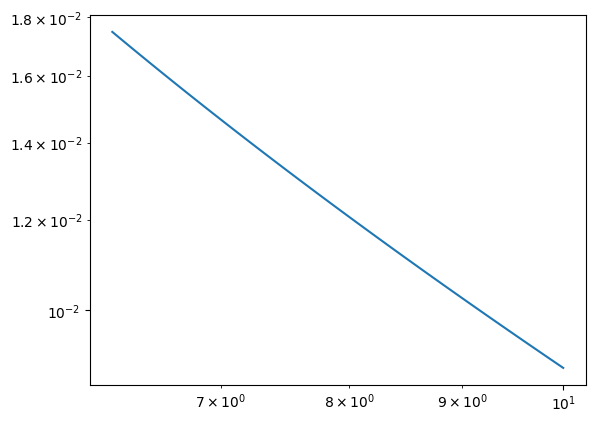

In [10]:
temps = np.linspace(1000, 1600, num=100)
plt.plot(1e4/temps, 1/logK_SiOs (temps))
plt.xscale('log')
plt.yscale('log')